In [ ]:
#this notebook contains our final model which generated the best recall of 0.958 
#and a high overall score. 

In [ ]:
#Training images

!wget https://alabama.box.com/s/isylwsjb5wphq0owgjl1hx12xad81w2a

In [ ]:
!gzip -d Training_0.2.zip

In [ ]:
#Test images

!wget https://alabama.box.com/s/254plk0zo7uez06gvn1kjbqfb0li2brf

In [ ]:
!gzip -d Test_0.2.zip

In [4]:
import os
import os.path as path
import shutil
import natsort
import glob
import numpy as np
from numpy import save, load
import os.path as path
import imageio
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model, save_model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, LeakyReLU, BatchNormalization
from keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from datetime import datetime
import keras
from keras import regularizers
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, precision_recall_curve, auc,recall_score
from keras.optimizers import Adam
from keras.regularizers import l2
import h5py
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from keras.backend import cast, greater, clip, floatx,epsilon
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, make_scorer, fbeta_score
from matplotlib import pyplot
from tensorflow import image
import tensorflow as tf
import pandas as pd

In [5]:
len_dataset = 16000

In [6]:
train_images = load('train_all.npy')
train_images.shape

(16000, 75, 75, 4)

In [7]:
train_images = train_images[0:len_dataset]

In [8]:
train_images.shape

(16000, 75, 75, 4)

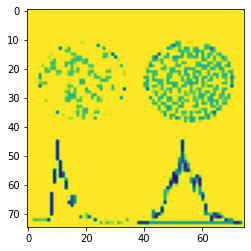

In [25]:
single_image = train_images[0,:,:,0]
pyplot.imshow(single_image)

In [9]:
labels = load('labels_train_all.npy')


In [10]:
labels = labels[:len_dataset]

In [11]:
labels.shape

(16000,)

In [12]:
# Split into test and training sets

n_images = train_images.shape[0]

TRAIN_TEST_SPLIT = 0.8            

# Split at the given index
split_index = int(TRAIN_TEST_SPLIT * n_images)
shuffled_indices = np.random.permutation(n_images)
train_indices = shuffled_indices[0:split_index]
test_indices = shuffled_indices[split_index:]

# Split the images and the labels
x_train = train_images[train_indices, :, :, :]
y_train = labels[train_indices]
x_val = train_images[test_indices, :, :, :]
y_val = labels[test_indices]



#Grid Search

In [15]:
def create_model(activation='relu', kernel_size=3, kernel_initializer='TruncatedNormal', drop_rate=0.25, lr = 0.01): 
  shape = train_images.shape[1:]
  model = Sequential()
  model.add(Conv2D(32, activation=activation, kernel_size=kernel_size, padding='same', kernel_initializer=kernel_initializer, input_shape=shape))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(drop_rate))
  model.add(Conv2D(64, activation=activation, kernel_size=kernel_size, padding='same', kernel_initializer=kernel_initializer))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(drop_rate))
  model.add(Flatten())
  model.add(Dense(128, activation=activation, kernel_initializer=kernel_initializer))
  model.add(BatchNormalization())
  model.add(Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer))
  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr), metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()], ver)
  return model 

In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1.e-6)
early_stopping_cb = EarlyStopping(monitor='loss', patience=5)
callbacks = [reduce_lr, early_stopping_cb]

In [95]:
estimator = KerasClassifier(create_model)

In [96]:
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'rec' : 'recall', 'prec' : 'precision', 'f2' : make_scorer(fbeta_score, beta=2)}
params_to_test_gen = {'epochs':[500], 'batch_size': [50,100,200,300,400], 'lr': [0.005,0.001,0.01], 'activation' : ['relu','elu','gelu'], 
                      'kernel_size' : [7,9,11,13], 
                      'kernel_initializer' : ['TruncatedNormal', 'lecun_normal','he_normal','glorot_normal','he_uniform','glorot_uniform','lecun_uniform'],
                      'drop_rate' : [0.,0.2,0.25,0.3,0.4,0.5]}
rvsearch_0 = RandomizedSearchCV( n_iter = 50,  estimator = estimator, param_distributions = params_to_test_gen, scoring=scoring, refit='f2', cv=StratifiedKFold(n_splits=3, shuffle = True, random_state = 0), verbose = 5)
rvsearch_0.fit(x_train, y_train, verbose=1, validation_data=(x_val, y_val), callbacks=callbacks)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] lr=0.01, kernel_size=11, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.3, batch_size=100, activation=elu 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/500
32/32 [==============================] - 3s 45ms/step - loss: 0.7172 - accuracy: 0.7037 - precision_304: 0.6945 - recall_304: 0.6852 - val_loss: 318.2298 - val_accuracy: 0.5142 - val_precision_304: 0.5142 - val_recall_304: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 32ms/step - loss: 0.4680 - accuracy: 0.7750 - precision_304: 0.7702 - recall_304: 0.7809 - val_loss: 42.9151 - val_accuracy: 0.5142 - val_precision_304: 0.5142 - val_recall_304: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 32ms/step - loss: 0.4492 - accuracy: 0.7922 - precision_304: 0.7883 - recall_304: 0.7853 - val_loss: 15.4475 - val_accuracy: 0.5142 - val_precision_304: 0.5142 - val_recall_304: 1.0000
Epoch 4/500
32/32 [==============================] - 1s 32ms/step - loss: 0.4477 - accuracy: 0.7940 - precision_304: 0.7974 - recall_304: 0.7909 - val_loss: 2.1348 - val_accuracy: 0.4992 - val_precision_304: 0.9000 - val_recall_304: 0.0292
Epoch 5/500
32/32 [=================

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.2s remaining:    0.0s


[CV]  lr=0.01, kernel_size=11, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.3, batch_size=100, activation=elu, AUC=0.918, Accuracy=0.831, f2=0.845, prec=0.816, rec=0.853, total=  22.2s
[CV] lr=0.01, kernel_size=11, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.3, batch_size=100, activation=elu 
Epoch 1/500
32/32 [==============================] - 3s 46ms/step - loss: 0.7212 - accuracy: 0.6914 - precision_305: 0.6932 - recall_305: 0.7005 - val_loss: 122.2625 - val_accuracy: 0.5142 - val_precision_305: 0.5142 - val_recall_305: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 32ms/step - loss: 0.4725 - accuracy: 0.7711 - precision_305: 0.7852 - recall_305: 0.7348 - val_loss: 18.8644 - val_accuracy: 0.5142 - val_precision_305: 0.5142 - val_recall_305: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 32ms/step - loss: 0.4190 - accuracy: 0.8027 - precision_305: 0.7843 - recall_305: 0.8331 - val_loss: 2.4818 - val_accuracy: 0.5142 - val_pre

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   41.8s remaining:    0.0s


[CV]  lr=0.01, kernel_size=11, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.3, batch_size=100, activation=elu, AUC=0.896, Accuracy=0.691, f2=0.457, prec=0.933, rec=0.406, total=  19.6s
[CV] lr=0.01, kernel_size=11, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.3, batch_size=100, activation=elu 
Epoch 1/500
32/32 [==============================] - 3s 45ms/step - loss: 0.8058 - accuracy: 0.6796 - precision_306: 0.6761 - recall_306: 0.6700 - val_loss: 179.7512 - val_accuracy: 0.5142 - val_precision_306: 0.5142 - val_recall_306: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 32ms/step - loss: 0.5012 - accuracy: 0.7442 - precision_306: 0.7697 - recall_306: 0.6994 - val_loss: 31.8712 - val_accuracy: 0.5142 - val_precision_306: 0.5142 - val_recall_306: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 32ms/step - loss: 0.4581 - accuracy: 0.7794 - precision_306: 0.7760 - recall_306: 0.7751 - val_loss: 4.7094 - val_accuracy: 0.5142 - val_pre

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min remaining:    0.0s


[CV]  lr=0.01, kernel_size=11, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.3, batch_size=100, activation=elu, AUC=0.905, Accuracy=0.646, f2=0.356, prec=0.932, rec=0.309, total=  18.5s
[CV] lr=0.005, kernel_size=9, kernel_initializer=TruncatedNormal, epochs=500, drop_rate=0.25, batch_size=100, activation=elu 
Epoch 1/500
32/32 [==============================] - 2s 42ms/step - loss: 0.5414 - accuracy: 0.7233 - precision_307: 0.7160 - recall_307: 0.7166 - val_loss: 33.9500 - val_accuracy: 0.5142 - val_precision_307: 0.5142 - val_recall_307: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 31ms/step - loss: 0.4373 - accuracy: 0.7912 - precision_307: 0.7806 - recall_307: 0.8114 - val_loss: 32.1353 - val_accuracy: 0.5142 - val_precision_307: 0.5142 - val_recall_307: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 31ms/step - loss: 0.4238 - accuracy: 0.7999 - precision_307: 0.7971 - recall_307: 0.7966 - val_loss: 11.4312 - val_accuracy: 0.4858 - val_

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sam

[CV]  lr=0.005, kernel_size=9, kernel_initializer=TruncatedNormal, epochs=500, drop_rate=0.25, batch_size=100, activation=elu, AUC=0.907, Accuracy=0.503, f2=0.000, prec=0.000, rec=0.000, total=  22.2s
[CV] lr=0.005, kernel_size=9, kernel_initializer=TruncatedNormal, epochs=500, drop_rate=0.25, batch_size=100, activation=elu 
Epoch 1/500
32/32 [==============================] - 3s 44ms/step - loss: 0.5648 - accuracy: 0.6903 - precision_308: 0.6819 - recall_308: 0.6891 - val_loss: 16.0196 - val_accuracy: 0.5142 - val_precision_308: 0.5142 - val_recall_308: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 31ms/step - loss: 0.4047 - accuracy: 0.8136 - precision_308: 0.8031 - recall_308: 0.8269 - val_loss: 6.1826 - val_accuracy: 0.4858 - val_precision_308: 0.0000e+00 - val_recall_308: 0.0000e+00
Epoch 3/500
32/32 [==============================] - 1s 31ms/step - loss: 0.3607 - accuracy: 0.8406 - precision_308: 0.8280 - recall_308: 0.8560 - val_loss: 38.5396 - val_accuracy: 0.4

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=9, kernel_initializer=TruncatedNormal, epochs=500, drop_rate=0.25, batch_size=100, activation=elu, AUC=0.896, Accuracy=0.807, f2=0.827, prec=0.788, rec=0.838, total=  37.1s
[CV] lr=0.005, kernel_size=9, kernel_initializer=TruncatedNormal, epochs=500, drop_rate=0.25, batch_size=100, activation=elu 
Epoch 1/500
32/32 [==============================] - 3s 44ms/step - loss: 0.5329 - accuracy: 0.7228 - precision_309: 0.7226 - recall_309: 0.7241 - val_loss: 16.9933 - val_accuracy: 0.4858 - val_precision_309: 0.0000e+00 - val_recall_309: 0.0000e+00
Epoch 2/500
32/32 [==============================] - 1s 31ms/step - loss: 0.4285 - accuracy: 0.8031 - precision_309: 0.7848 - recall_309: 0.8254 - val_loss: 18.1590 - val_accuracy: 0.4858 - val_precision_309: 0.0000e+00 - val_recall_309: 0.0000e+00
Epoch 3/500
32/32 [==============================] - 1s 32ms/step - loss: 0.4043 - accuracy: 0.8192 - precision_309: 0.8021 - recall_309: 0.8351 - val_loss: 0.6491 - val_accur

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=9, kernel_initializer=TruncatedNormal, epochs=500, drop_rate=0.25, batch_size=100, activation=elu, AUC=0.910, Accuracy=0.815, f2=0.774, prec=0.854, rec=0.757, total=  21.4s
[CV] lr=0.005, kernel_size=13, kernel_initializer=he_uniform, epochs=500, drop_rate=0.5, batch_size=300, activation=relu 
Epoch 1/500
11/11 [==============================] - 4s 177ms/step - loss: 0.8671 - accuracy: 0.6310 - precision_310: 0.6162 - recall_310: 0.6208 - val_loss: 168.6884 - val_accuracy: 0.5142 - val_precision_310: 0.5142 - val_recall_310: 1.0000
Epoch 2/500
11/11 [==============================] - 1s 77ms/step - loss: 0.5188 - accuracy: 0.7548 - precision_310: 0.7489 - recall_310: 0.7745 - val_loss: 83.8754 - val_accuracy: 0.5142 - val_precision_310: 0.5142 - val_recall_310: 1.0000
Epoch 3/500
11/11 [==============================] - 1s 76ms/step - loss: 0.4686 - accuracy: 0.7801 - precision_310: 0.7631 - recall_310: 0.8058 - val_loss: 56.3477 - val_accuracy: 0.5142 - val

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=13, kernel_initializer=he_uniform, epochs=500, drop_rate=0.5, batch_size=300, activation=relu, AUC=0.417, Accuracy=0.469, f2=0.339, prec=0.452, rec=0.319, total=  17.2s
[CV] lr=0.005, kernel_size=13, kernel_initializer=he_uniform, epochs=500, drop_rate=0.5, batch_size=300, activation=relu 
Epoch 1/500
11/11 [==============================] - 2s 116ms/step - loss: 0.8578 - accuracy: 0.6398 - precision_311: 0.6300 - recall_311: 0.6419 - val_loss: 58.3088 - val_accuracy: 0.5142 - val_precision_311: 0.5142 - val_recall_311: 1.0000
Epoch 2/500
11/11 [==============================] - 1s 75ms/step - loss: 0.4880 - accuracy: 0.7678 - precision_311: 0.7601 - recall_311: 0.7740 - val_loss: 66.5749 - val_accuracy: 0.5142 - val_precision_311: 0.5142 - val_recall_311: 1.0000
Epoch 3/500
11/11 [==============================] - 1s 75ms/step - loss: 0.4467 - accuracy: 0.7943 - precision_311: 0.7810 - recall_311: 0.8225 - val_loss: 50.0212 - val_accuracy: 0.5142 - val_prec

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=13, kernel_initializer=he_uniform, epochs=500, drop_rate=0.5, batch_size=300, activation=relu, AUC=0.829, Accuracy=0.522, f2=0.838, prec=0.509, rec=0.999, total=  20.4s
[CV] lr=0.005, kernel_size=13, kernel_initializer=he_uniform, epochs=500, drop_rate=0.5, batch_size=300, activation=relu 
Epoch 1/500
11/11 [==============================] - 3s 117ms/step - loss: 0.8649 - accuracy: 0.6265 - precision_312: 0.6221 - recall_312: 0.6226 - val_loss: 120.3740 - val_accuracy: 0.5142 - val_precision_312: 0.5142 - val_recall_312: 1.0000
Epoch 2/500
11/11 [==============================] - 1s 76ms/step - loss: 0.5219 - accuracy: 0.7477 - precision_312: 0.7607 - recall_312: 0.7357 - val_loss: 78.5787 - val_accuracy: 0.5142 - val_precision_312: 0.5142 - val_recall_312: 1.0000
Epoch 3/500
11/11 [==============================] - 1s 76ms/step - loss: 0.4978 - accuracy: 0.7511 - precision_312: 0.7517 - recall_312: 0.7626 - val_loss: 28.3048 - val_accuracy: 0.5142 - val_pre

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=13, kernel_initializer=he_uniform, epochs=500, drop_rate=0.5, batch_size=300, activation=relu, AUC=0.899, Accuracy=0.679, f2=0.880, prec=0.608, rec=0.990, total=  30.8s
[CV] lr=0.005, kernel_size=7, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.4, batch_size=200, activation=elu 
Epoch 1/500
16/16 [==============================] - 2s 78ms/step - loss: 0.7529 - accuracy: 0.6670 - precision_313: 0.6640 - recall_313: 0.6763 - val_loss: 12.4605 - val_accuracy: 0.5142 - val_precision_313: 0.5142 - val_recall_313: 1.0000
Epoch 2/500
16/16 [==============================] - 1s 51ms/step - loss: 0.4748 - accuracy: 0.7751 - precision_313: 0.7742 - recall_313: 0.7826 - val_loss: 13.2998 - val_accuracy: 0.5142 - val_precision_313: 0.5142 - val_recall_313: 1.0000
Epoch 3/500
16/16 [==============================] - 1s 51ms/step - loss: 0.4202 - accuracy: 0.7987 - precision_313: 0.7927 - recall_313: 0.8095 - val_loss: 0.6260 - val_accuracy: 0.6267 - val_preci

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=7, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.4, batch_size=200, activation=elu, AUC=0.914, Accuracy=0.734, f2=0.896, prec=0.654, rec=0.987, total=  18.6s
[CV] lr=0.005, kernel_size=7, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.4, batch_size=200, activation=elu 
Epoch 1/500
16/16 [==============================] - 2s 79ms/step - loss: 0.6401 - accuracy: 0.6871 - precision_314: 0.6881 - recall_314: 0.6800 - val_loss: 20.4185 - val_accuracy: 0.5142 - val_precision_314: 0.5142 - val_recall_314: 1.0000
Epoch 2/500
16/16 [==============================] - 1s 51ms/step - loss: 0.4409 - accuracy: 0.7915 - precision_314: 0.7692 - recall_314: 0.8272 - val_loss: 4.3152 - val_accuracy: 0.5142 - val_precision_314: 0.5142 - val_recall_314: 1.0000
Epoch 3/500
16/16 [==============================] - 1s 52ms/step - loss: 0.4091 - accuracy: 0.8075 - precision_314: 0.7997 - recall_314: 0.8207 - val_loss: 7.8852 - val_accuracy: 0.5142 - val_preci

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=7, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.4, batch_size=200, activation=elu, AUC=0.893, Accuracy=0.675, f2=0.419, prec=0.942, rec=0.368, total=  17.6s
[CV] lr=0.005, kernel_size=7, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.4, batch_size=200, activation=elu 
Epoch 1/500
16/16 [==============================] - 2s 78ms/step - loss: 0.7006 - accuracy: 0.6703 - precision_315: 0.6620 - recall_315: 0.6611 - val_loss: 15.0292 - val_accuracy: 0.5142 - val_precision_315: 0.5142 - val_recall_315: 1.0000
Epoch 2/500
16/16 [==============================] - 1s 51ms/step - loss: 0.4637 - accuracy: 0.7792 - precision_315: 0.7826 - recall_315: 0.7802 - val_loss: 9.9228 - val_accuracy: 0.5142 - val_precision_315: 0.5142 - val_recall_315: 1.0000
Epoch 3/500
16/16 [==============================] - 1s 51ms/step - loss: 0.4230 - accuracy: 0.8028 - precision_315: 0.8040 - recall_315: 0.8057 - val_loss: 3.3723 - val_accuracy: 0.5142 - val_preci

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=7, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.4, batch_size=200, activation=elu, AUC=0.913, Accuracy=0.782, f2=0.670, prec=0.903, rec=0.630, total=  22.5s
[CV] lr=0.01, kernel_size=13, kernel_initializer=he_uniform, epochs=500, drop_rate=0.4, batch_size=100, activation=gelu 
Epoch 1/500
32/32 [==============================] - 4s 65ms/step - loss: 0.7491 - accuracy: 0.6651 - precision_316: 0.6625 - recall_316: 0.6727 - val_loss: 130.2360 - val_accuracy: 0.5142 - val_precision_316: 0.5142 - val_recall_316: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 39ms/step - loss: 0.4667 - accuracy: 0.7758 - precision_316: 0.7542 - recall_316: 0.8171 - val_loss: 19.5870 - val_accuracy: 0.5142 - val_precision_316: 0.5142 - val_recall_316: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 38ms/step - loss: 0.4594 - accuracy: 0.7821 - precision_316: 0.7717 - recall_316: 0.8064 - val_loss: 7.0332 - val_accuracy: 0.5142 - val_preci

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=13, kernel_initializer=he_uniform, epochs=500, drop_rate=0.4, batch_size=100, activation=gelu, AUC=0.917, Accuracy=0.830, f2=0.830, prec=0.828, rec=0.830, total=  31.5s
[CV] lr=0.01, kernel_size=13, kernel_initializer=he_uniform, epochs=500, drop_rate=0.4, batch_size=100, activation=gelu 
Epoch 1/500
32/32 [==============================] - 3s 52ms/step - loss: 0.6985 - accuracy: 0.6773 - precision_317: 0.6707 - recall_317: 0.6664 - val_loss: 243.4944 - val_accuracy: 0.5142 - val_precision_317: 0.5142 - val_recall_317: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 39ms/step - loss: 0.4934 - accuracy: 0.7676 - precision_317: 0.7684 - recall_317: 0.7714 - val_loss: 56.5917 - val_accuracy: 0.5142 - val_precision_317: 0.5142 - val_recall_317: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 38ms/step - loss: 0.4395 - accuracy: 0.7960 - precision_317: 0.8018 - recall_317: 0.7955 - val_loss: 17.4526 - val_accuracy: 0.5142 - val_precis

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=13, kernel_initializer=he_uniform, epochs=500, drop_rate=0.4, batch_size=100, activation=gelu, AUC=0.886, Accuracy=0.706, f2=0.507, prec=0.901, rec=0.457, total=  26.1s
[CV] lr=0.01, kernel_size=13, kernel_initializer=he_uniform, epochs=500, drop_rate=0.4, batch_size=100, activation=gelu 
Epoch 1/500
32/32 [==============================] - 3s 50ms/step - loss: 0.7492 - accuracy: 0.6792 - precision_318: 0.6811 - recall_318: 0.6718 - val_loss: 187.1317 - val_accuracy: 0.5142 - val_precision_318: 0.5142 - val_recall_318: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 37ms/step - loss: 0.4929 - accuracy: 0.7531 - precision_318: 0.7313 - recall_318: 0.7800 - val_loss: 36.4344 - val_accuracy: 0.5142 - val_precision_318: 0.5142 - val_recall_318: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 38ms/step - loss: 0.4452 - accuracy: 0.7939 - precision_318: 0.7712 - recall_318: 0.8380 - val_loss: 7.7603 - val_accuracy: 0.5142 - val_precisi

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=13, kernel_initializer=he_uniform, epochs=500, drop_rate=0.4, batch_size=100, activation=gelu, AUC=0.910, Accuracy=0.771, f2=0.650, prec=0.898, rec=0.608, total=  29.5s
[CV] lr=0.01, kernel_size=13, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.3, batch_size=100, activation=gelu 
Epoch 1/500
32/32 [==============================] - 3s 52ms/step - loss: 0.7173 - accuracy: 0.6693 - precision_319: 0.6781 - recall_319: 0.6547 - val_loss: 483.1552 - val_accuracy: 0.5142 - val_precision_319: 0.5142 - val_recall_319: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 38ms/step - loss: 0.4891 - accuracy: 0.7708 - precision_319: 0.7853 - recall_319: 0.7477 - val_loss: 82.0010 - val_accuracy: 0.5142 - val_precision_319: 0.5142 - val_recall_319: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 38ms/step - loss: 0.4839 - accuracy: 0.7664 - precision_319: 0.7629 - recall_319: 0.7614 - val_loss: 10.7864 - val_accuracy: 0.5142 - val_pr

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=13, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.3, batch_size=100, activation=gelu, AUC=0.911, Accuracy=0.806, f2=0.736, prec=0.879, rec=0.707, total=  24.7s
[CV] lr=0.01, kernel_size=13, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.3, batch_size=100, activation=gelu 
Epoch 1/500
32/32 [==============================] - 3s 66ms/step - loss: 0.7450 - accuracy: 0.6800 - precision_320: 0.6724 - recall_320: 0.6765 - val_loss: 165.6685 - val_accuracy: 0.5142 - val_precision_320: 0.5142 - val_recall_320: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 38ms/step - loss: 0.4613 - accuracy: 0.7815 - precision_320: 0.7826 - recall_320: 0.7929 - val_loss: 35.6551 - val_accuracy: 0.5142 - val_precision_320: 0.5142 - val_recall_320: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 38ms/step - loss: 0.4399 - accuracy: 0.7955 - precision_320: 0.7877 - recall_320: 0.8006 - val_loss: 14.7075 - val_accuracy: 0.5142 - va

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=13, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.3, batch_size=100, activation=gelu, AUC=0.890, Accuracy=0.735, f2=0.576, prec=0.894, rec=0.529, total=  25.1s
[CV] lr=0.01, kernel_size=13, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.3, batch_size=100, activation=gelu 
Epoch 1/500
32/32 [==============================] - 3s 54ms/step - loss: 0.7152 - accuracy: 0.6634 - precision_321: 0.6531 - recall_321: 0.6623 - val_loss: 233.6480 - val_accuracy: 0.5142 - val_precision_321: 0.5142 - val_recall_321: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 39ms/step - loss: 0.4879 - accuracy: 0.7584 - precision_321: 0.7580 - recall_321: 0.7473 - val_loss: 57.8876 - val_accuracy: 0.5142 - val_precision_321: 0.5142 - val_recall_321: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 39ms/step - loss: 0.4820 - accuracy: 0.7664 - precision_321: 0.7485 - recall_321: 0.7922 - val_loss: 16.1610 - val_accuracy: 0.5142 - va

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=13, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.3, batch_size=100, activation=gelu, AUC=0.896, Accuracy=0.529, f2=0.070, prec=0.918, rec=0.057, total=  23.6s
[CV] lr=0.001, kernel_size=11, kernel_initializer=he_normal, epochs=500, drop_rate=0.5, batch_size=300, activation=gelu 
Epoch 1/500
11/11 [==============================] - 4s 189ms/step - loss: 0.7293 - accuracy: 0.6412 - precision_322: 0.6364 - recall_322: 0.6512 - val_loss: 1.2362 - val_accuracy: 0.4858 - val_precision_322: 0.0000e+00 - val_recall_322: 0.0000e+00
Epoch 2/500
11/11 [==============================] - 1s 104ms/step - loss: 0.6320 - accuracy: 0.7258 - precision_322: 0.7335 - recall_322: 0.7077 - val_loss: 3.7775 - val_accuracy: 0.5142 - val_precision_322: 0.5142 - val_recall_322: 1.0000
Epoch 3/500
11/11 [==============================] - 1s 105ms/step - loss: 0.5153 - accuracy: 0.7535 - precision_322: 0.7431 - recall_322: 0.7676 - val_loss: 8.5033 - val_accuracy: 0.5142 -

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=11, kernel_initializer=he_normal, epochs=500, drop_rate=0.5, batch_size=300, activation=gelu, AUC=0.835, Accuracy=0.497, f2=0.832, prec=0.497, rec=1.000, total=  26.7s
[CV] lr=0.001, kernel_size=11, kernel_initializer=he_normal, epochs=500, drop_rate=0.5, batch_size=300, activation=gelu 
Epoch 1/500
11/11 [==============================] - 3s 151ms/step - loss: 0.7364 - accuracy: 0.6370 - precision_323: 0.6354 - recall_323: 0.6469 - val_loss: 0.6585 - val_accuracy: 0.6283 - val_precision_323: 0.8869 - val_recall_323: 0.3177
Epoch 2/500
11/11 [==============================] - 1s 105ms/step - loss: 0.5688 - accuracy: 0.7450 - precision_323: 0.7396 - recall_323: 0.7613 - val_loss: 14.8499 - val_accuracy: 0.5142 - val_precision_323: 0.5142 - val_recall_323: 1.0000
Epoch 3/500
11/11 [==============================] - 1s 106ms/step - loss: 0.4983 - accuracy: 0.7757 - precision_323: 0.7749 - recall_323: 0.7804 - val_loss: 15.2362 - val_accuracy: 0.5142 - val_preci

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=11, kernel_initializer=he_normal, epochs=500, drop_rate=0.5, batch_size=300, activation=gelu, AUC=0.829, Accuracy=0.496, f2=0.831, prec=0.496, rec=1.000, total=  28.1s
[CV] lr=0.001, kernel_size=11, kernel_initializer=he_normal, epochs=500, drop_rate=0.5, batch_size=300, activation=gelu 
Epoch 1/500
11/11 [==============================] - 4s 151ms/step - loss: 0.7868 - accuracy: 0.6340 - precision_324: 0.6224 - recall_324: 0.6436 - val_loss: 0.5367 - val_accuracy: 0.7300 - val_precision_324: 0.6767 - val_recall_324: 0.9092
Epoch 2/500
11/11 [==============================] - 1s 105ms/step - loss: 0.6869 - accuracy: 0.7180 - precision_324: 0.7049 - recall_324: 0.7320 - val_loss: 5.9865 - val_accuracy: 0.5142 - val_precision_324: 0.5142 - val_recall_324: 1.0000
Epoch 3/500
11/11 [==============================] - 1s 105ms/step - loss: 0.5867 - accuracy: 0.7410 - precision_324: 0.7468 - recall_324: 0.7329 - val_loss: 6.9608 - val_accuracy: 0.5142 - val_precisi

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=11, kernel_initializer=he_normal, epochs=500, drop_rate=0.5, batch_size=300, activation=gelu, AUC=0.859, Accuracy=0.496, f2=0.831, prec=0.496, rec=1.000, total=  18.0s
[CV] lr=0.001, kernel_size=7, kernel_initializer=he_normal, epochs=500, drop_rate=0.3, batch_size=200, activation=relu 
Epoch 1/500
16/16 [==============================] - 2s 76ms/step - loss: 0.6838 - accuracy: 0.6657 - precision_325: 0.6625 - recall_325: 0.6620 - val_loss: 1.7714 - val_accuracy: 0.5142 - val_precision_325: 0.5142 - val_recall_325: 1.0000
Epoch 2/500
16/16 [==============================] - 1s 47ms/step - loss: 0.4744 - accuracy: 0.7714 - precision_325: 0.7649 - recall_325: 0.7913 - val_loss: 7.3501 - val_accuracy: 0.5142 - val_precision_325: 0.5142 - val_recall_325: 1.0000
Epoch 3/500
16/16 [==============================] - 1s 47ms/step - loss: 0.4487 - accuracy: 0.7841 - precision_325: 0.7724 - recall_325: 0.7882 - val_loss: 10.7024 - val_accuracy: 0.5142 - val_precision_

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=7, kernel_initializer=he_normal, epochs=500, drop_rate=0.3, batch_size=200, activation=relu, AUC=0.877, Accuracy=0.497, f2=0.832, prec=0.497, rec=1.000, total=  12.9s
[CV] lr=0.001, kernel_size=7, kernel_initializer=he_normal, epochs=500, drop_rate=0.3, batch_size=200, activation=relu 
Epoch 1/500
16/16 [==============================] - 2s 74ms/step - loss: 0.6956 - accuracy: 0.6944 - precision_326: 0.6995 - recall_326: 0.7007 - val_loss: 11.0269 - val_accuracy: 0.5142 - val_precision_326: 0.5142 - val_recall_326: 1.0000
Epoch 2/500
16/16 [==============================] - 1s 48ms/step - loss: 0.4637 - accuracy: 0.7893 - precision_326: 0.7835 - recall_326: 0.7928 - val_loss: 18.1529 - val_accuracy: 0.5142 - val_precision_326: 0.5142 - val_recall_326: 1.0000
Epoch 3/500
16/16 [==============================] - 1s 48ms/step - loss: 0.4063 - accuracy: 0.8182 - precision_326: 0.8240 - recall_326: 0.8100 - val_loss: 17.4702 - val_accuracy: 0.5142 - val_precision

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=7, kernel_initializer=he_normal, epochs=500, drop_rate=0.3, batch_size=200, activation=relu, AUC=0.883, Accuracy=0.748, f2=0.600, prec=0.898, rec=0.554, total=  20.8s
[CV] lr=0.001, kernel_size=7, kernel_initializer=he_normal, epochs=500, drop_rate=0.3, batch_size=200, activation=relu 
Epoch 1/500
16/16 [==============================] - 2s 76ms/step - loss: 0.7285 - accuracy: 0.6687 - precision_327: 0.6622 - recall_327: 0.6770 - val_loss: 12.1772 - val_accuracy: 0.5142 - val_precision_327: 0.5142 - val_recall_327: 1.0000
Epoch 2/500
16/16 [==============================] - 1s 48ms/step - loss: 0.4936 - accuracy: 0.7700 - precision_327: 0.7635 - recall_327: 0.7783 - val_loss: 17.9760 - val_accuracy: 0.5142 - val_precision_327: 0.5142 - val_recall_327: 1.0000
Epoch 3/500
16/16 [==============================] - 1s 48ms/step - loss: 0.4276 - accuracy: 0.8003 - precision_327: 0.7892 - recall_327: 0.8107 - val_loss: 12.3893 - val_accuracy: 0.5142 - val_precision

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=7, kernel_initializer=he_normal, epochs=500, drop_rate=0.3, batch_size=200, activation=relu, AUC=0.897, Accuracy=0.738, f2=0.578, prec=0.901, rec=0.530, total=  19.9s
[CV] lr=0.01, kernel_size=9, kernel_initializer=TruncatedNormal, epochs=500, drop_rate=0.3, batch_size=50, activation=gelu 
Epoch 1/500
64/64 [==============================] - 3s 29ms/step - loss: 0.5614 - accuracy: 0.6958 - precision_328: 0.6896 - recall_328: 0.6980 - val_loss: 55.4516 - val_accuracy: 0.5142 - val_precision_328: 0.5142 - val_recall_328: 1.0000
Epoch 2/500
64/64 [==============================] - 1s 22ms/step - loss: 0.4635 - accuracy: 0.7845 - precision_328: 0.7691 - recall_328: 0.8044 - val_loss: 19.8335 - val_accuracy: 0.5142 - val_precision_328: 0.5142 - val_recall_328: 1.0000
Epoch 3/500
64/64 [==============================] - 1s 22ms/step - loss: 0.4331 - accuracy: 0.7979 - precision_328: 0.7780 - recall_328: 0.8098 - val_loss: 11.3014 - val_accuracy: 0.5142 - val_preci

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=9, kernel_initializer=TruncatedNormal, epochs=500, drop_rate=0.3, batch_size=50, activation=gelu, AUC=0.917, Accuracy=0.816, f2=0.750, prec=0.886, rec=0.722, total=  37.1s
[CV] lr=0.01, kernel_size=9, kernel_initializer=TruncatedNormal, epochs=500, drop_rate=0.3, batch_size=50, activation=gelu 
Epoch 1/500
64/64 [==============================] - 3s 28ms/step - loss: 0.5498 - accuracy: 0.7268 - precision_329: 0.7212 - recall_329: 0.7289 - val_loss: 135.2341 - val_accuracy: 0.5142 - val_precision_329: 0.5142 - val_recall_329: 1.0000
Epoch 2/500
64/64 [==============================] - 1s 21ms/step - loss: 0.4227 - accuracy: 0.7967 - precision_329: 0.7894 - recall_329: 0.8114 - val_loss: 80.6599 - val_accuracy: 0.5142 - val_precision_329: 0.5142 - val_recall_329: 1.0000
Epoch 3/500
64/64 [==============================] - 1s 23ms/step - loss: 0.4270 - accuracy: 0.8021 - precision_329: 0.7858 - recall_329: 0.8047 - val_loss: 4.8342 - val_accuracy: 0.4867 - val_p

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=9, kernel_initializer=TruncatedNormal, epochs=500, drop_rate=0.3, batch_size=50, activation=gelu, AUC=0.900, Accuracy=0.803, f2=0.756, prec=0.847, rec=0.737, total=  38.3s
[CV] lr=0.01, kernel_size=9, kernel_initializer=TruncatedNormal, epochs=500, drop_rate=0.3, batch_size=50, activation=gelu 
Epoch 1/500
64/64 [==============================] - 3s 29ms/step - loss: 0.5436 - accuracy: 0.7147 - precision_330: 0.7171 - recall_330: 0.7004 - val_loss: 53.5022 - val_accuracy: 0.5142 - val_precision_330: 0.5142 - val_recall_330: 1.0000
Epoch 2/500
64/64 [==============================] - 1s 22ms/step - loss: 0.4448 - accuracy: 0.7870 - precision_330: 0.7706 - recall_330: 0.8057 - val_loss: 7.4151 - val_accuracy: 0.5142 - val_precision_330: 0.5142 - val_recall_330: 1.0000
Epoch 3/500
64/64 [==============================] - 1s 22ms/step - loss: 0.4225 - accuracy: 0.7955 - precision_330: 0.7695 - recall_330: 0.8217 - val_loss: 1.3816 - val_accuracy: 0.5142 - val_pre

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=9, kernel_initializer=TruncatedNormal, epochs=500, drop_rate=0.3, batch_size=50, activation=gelu, AUC=0.908, Accuracy=0.821, f2=0.864, prec=0.782, rec=0.888, total=  35.5s
[CV] lr=0.005, kernel_size=11, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.5, batch_size=300, activation=gelu 
Epoch 1/500
11/11 [==============================] - 3s 151ms/step - loss: 0.6971 - accuracy: 0.6499 - precision_331: 0.6613 - recall_331: 0.6566 - val_loss: 0.5776 - val_accuracy: 0.7542 - val_precision_331: 0.7361 - val_recall_331: 0.8136
Epoch 2/500
11/11 [==============================] - 1s 105ms/step - loss: 0.4996 - accuracy: 0.7621 - precision_331: 0.7629 - recall_331: 0.7625 - val_loss: 32.0584 - val_accuracy: 0.5142 - val_precision_331: 0.5142 - val_recall_331: 1.0000
Epoch 3/500
11/11 [==============================] - 1s 105ms/step - loss: 0.4664 - accuracy: 0.7813 - precision_331: 0.7939 - recall_331: 0.7714 - val_loss: 18.7793 - val_accuracy: 0.5142 - va

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=11, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.5, batch_size=300, activation=gelu, AUC=0.702, Accuracy=0.497, f2=0.832, prec=0.497, rec=1.000, total=  17.7s
[CV] lr=0.005, kernel_size=11, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.5, batch_size=300, activation=gelu 
Epoch 1/500
11/11 [==============================] - 4s 189ms/step - loss: 0.7009 - accuracy: 0.6528 - precision_332: 0.6575 - recall_332: 0.6280 - val_loss: 84.3388 - val_accuracy: 0.5142 - val_precision_332: 0.5142 - val_recall_332: 1.0000
Epoch 2/500
11/11 [==============================] - 1s 105ms/step - loss: 0.4820 - accuracy: 0.7683 - precision_332: 0.7543 - recall_332: 0.7865 - val_loss: 69.4641 - val_accuracy: 0.5142 - val_precision_332: 0.5142 - val_recall_332: 1.0000
Epoch 3/500
11/11 [==============================] - 1s 104ms/step - loss: 0.4315 - accuracy: 0.8006 - precision_332: 0.7818 - recall_332: 0.8145 - val_loss: 56.8772 - val_accuracy: 0.5142 - 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=11, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.5, batch_size=300, activation=gelu, AUC=0.802, Accuracy=0.496, f2=0.831, prec=0.496, rec=1.000, total=  29.5s
[CV] lr=0.005, kernel_size=11, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.5, batch_size=300, activation=gelu 
Epoch 1/500
11/11 [==============================] - 3s 148ms/step - loss: 0.7507 - accuracy: 0.6482 - precision_333: 0.6517 - recall_333: 0.6485 - val_loss: 93.7852 - val_accuracy: 0.5142 - val_precision_333: 0.5142 - val_recall_333: 1.0000
Epoch 2/500
11/11 [==============================] - 1s 105ms/step - loss: 0.5012 - accuracy: 0.7576 - precision_333: 0.7586 - recall_333: 0.7391 - val_loss: 63.0082 - val_accuracy: 0.5142 - val_precision_333: 0.5142 - val_recall_333: 1.0000
Epoch 3/500
11/11 [==============================] - 1s 105ms/step - loss: 0.4657 - accuracy: 0.7688 - precision_333: 0.7608 - recall_333: 0.7822 - val_loss: 50.3570 - val_accuracy: 0.5142 - 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sam

[CV]  lr=0.005, kernel_size=11, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.5, batch_size=300, activation=gelu, AUC=0.879, Accuracy=0.504, f2=0.000, prec=0.000, rec=0.000, total=  27.9s
[CV] lr=0.01, kernel_size=11, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.2, batch_size=400, activation=gelu 
Epoch 1/500
8/8 [==============================] - 3s 191ms/step - loss: 0.8520 - accuracy: 0.6093 - precision_334: 0.6165 - recall_334: 0.6027 - val_loss: 925.2260 - val_accuracy: 0.5142 - val_precision_334: 0.5142 - val_recall_334: 1.0000
Epoch 2/500
8/8 [==============================] - 1s 133ms/step - loss: 0.5025 - accuracy: 0.7565 - precision_334: 0.7658 - recall_334: 0.7492 - val_loss: 869.1456 - val_accuracy: 0.5142 - val_precision_334: 0.5142 - val_recall_334: 1.0000
Epoch 3/500
8/8 [==============================] - 1s 130ms/step - loss: 0.4806 - accuracy: 0.7656 - precision_334: 0.7693 - recall_334: 0.7604 - val_loss: 499.3118 - val_accuracy: 0.5142 - val_

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=11, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.2, batch_size=400, activation=gelu, AUC=0.890, Accuracy=0.530, f2=0.067, prec=1.000, rec=0.054, total=  33.1s
[CV] lr=0.01, kernel_size=11, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.2, batch_size=400, activation=gelu 
Epoch 1/500
8/8 [==============================] - 3s 192ms/step - loss: 0.8567 - accuracy: 0.6342 - precision_335: 0.6407 - recall_335: 0.6226 - val_loss: 910.0059 - val_accuracy: 0.5142 - val_precision_335: 0.5142 - val_recall_335: 1.0000
Epoch 2/500
8/8 [==============================] - 1s 132ms/step - loss: 0.4968 - accuracy: 0.7718 - precision_335: 0.7439 - recall_335: 0.8161 - val_loss: 658.2333 - val_accuracy: 0.5142 - val_precision_335: 0.5142 - val_recall_335: 1.0000
Epoch 3/500
8/8 [==============================] - 1s 131ms/step - loss: 0.4678 - accuracy: 0.7739 - precision_335: 0.7992 - recall_335: 0.7328 - val_loss: 423.5605 - val_accuracy: 0.5142 - val_p

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=11, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.2, batch_size=400, activation=gelu, AUC=0.831, Accuracy=0.687, f2=0.506, prec=0.834, rec=0.461, total=  33.6s
[CV] lr=0.01, kernel_size=11, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.2, batch_size=400, activation=gelu 
Epoch 1/500
8/8 [==============================] - 3s 200ms/step - loss: 1.0067 - accuracy: 0.6002 - precision_336: 0.5943 - recall_336: 0.5823 - val_loss: 775.8750 - val_accuracy: 0.5142 - val_precision_336: 0.5142 - val_recall_336: 1.0000
Epoch 2/500
8/8 [==============================] - 1s 131ms/step - loss: 0.5142 - accuracy: 0.7571 - precision_336: 0.7370 - recall_336: 0.7953 - val_loss: 476.4071 - val_accuracy: 0.5142 - val_precision_336: 0.5142 - val_recall_336: 1.0000
Epoch 3/500
8/8 [==============================] - 1s 131ms/step - loss: 0.4911 - accuracy: 0.7593 - precision_336: 0.7711 - recall_336: 0.7450 - val_loss: 334.8008 - val_accuracy: 0.5142 - val_p

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=11, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.2, batch_size=400, activation=gelu, AUC=0.260, Accuracy=0.496, f2=0.831, prec=0.496, rec=1.000, total=  25.7s
[CV] lr=0.005, kernel_size=7, kernel_initializer=he_normal, epochs=500, drop_rate=0.25, batch_size=300, activation=elu 
Epoch 1/500
11/11 [==============================] - 3s 116ms/step - loss: 0.8853 - accuracy: 0.6859 - precision_337: 0.6803 - recall_337: 0.7050 - val_loss: 29.6504 - val_accuracy: 0.5142 - val_precision_337: 0.5142 - val_recall_337: 1.0000
Epoch 2/500
11/11 [==============================] - 1s 73ms/step - loss: 0.4480 - accuracy: 0.7860 - precision_337: 0.8016 - recall_337: 0.7725 - val_loss: 6.5132 - val_accuracy: 0.5142 - val_precision_337: 0.5142 - val_recall_337: 1.0000
Epoch 3/500
11/11 [==============================] - 1s 73ms/step - loss: 0.4203 - accuracy: 0.8142 - precision_337: 0.8127 - recall_337: 0.8070 - val_loss: 17.2559 - val_accuracy: 0.4858 - val_preci

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=7, kernel_initializer=he_normal, epochs=500, drop_rate=0.25, batch_size=300, activation=elu, AUC=0.915, Accuracy=0.553, f2=0.123, prec=1.000, rec=0.101, total=  17.5s
[CV] lr=0.005, kernel_size=7, kernel_initializer=he_normal, epochs=500, drop_rate=0.25, batch_size=300, activation=elu 
Epoch 1/500
11/11 [==============================] - 3s 116ms/step - loss: 0.8266 - accuracy: 0.6813 - precision_338: 0.6724 - recall_338: 0.6945 - val_loss: 38.9899 - val_accuracy: 0.5142 - val_precision_338: 0.5142 - val_recall_338: 1.0000
Epoch 2/500
11/11 [==============================] - 1s 71ms/step - loss: 0.4269 - accuracy: 0.8115 - precision_338: 0.8179 - recall_338: 0.8006 - val_loss: 26.1650 - val_accuracy: 0.5142 - val_precision_338: 0.5142 - val_recall_338: 1.0000
Epoch 3/500
11/11 [==============================] - 1s 72ms/step - loss: 0.3933 - accuracy: 0.8204 - precision_338: 0.8128 - recall_338: 0.8310 - val_loss: 3.7407 - val_accuracy: 0.5142 - val_precision

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=7, kernel_initializer=he_normal, epochs=500, drop_rate=0.25, batch_size=300, activation=elu, AUC=0.880, Accuracy=0.677, f2=0.876, prec=0.608, rec=0.985, total=  26.0s
[CV] lr=0.005, kernel_size=7, kernel_initializer=he_normal, epochs=500, drop_rate=0.25, batch_size=300, activation=elu 
Epoch 1/500
11/11 [==============================] - 3s 115ms/step - loss: 0.8741 - accuracy: 0.6528 - precision_339: 0.6448 - recall_339: 0.6741 - val_loss: 41.1928 - val_accuracy: 0.5142 - val_precision_339: 0.5142 - val_recall_339: 1.0000
Epoch 2/500
11/11 [==============================] - 1s 71ms/step - loss: 0.4406 - accuracy: 0.7875 - precision_339: 0.7839 - recall_339: 0.7739 - val_loss: 12.0541 - val_accuracy: 0.5142 - val_precision_339: 0.5142 - val_recall_339: 1.0000
Epoch 3/500
11/11 [==============================] - 1s 74ms/step - loss: 0.4052 - accuracy: 0.8067 - precision_339: 0.7920 - recall_339: 0.8291 - val_loss: 7.8108 - val_accuracy: 0.4858 - val_precision

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sam

[CV]  lr=0.005, kernel_size=7, kernel_initializer=he_normal, epochs=500, drop_rate=0.25, batch_size=300, activation=elu, AUC=0.900, Accuracy=0.504, f2=0.000, prec=0.000, rec=0.000, total=  20.6s
[CV] lr=0.005, kernel_size=13, kernel_initializer=he_normal, epochs=500, drop_rate=0.4, batch_size=100, activation=relu 
Epoch 1/500
32/32 [==============================] - 3s 58ms/step - loss: 0.6456 - accuracy: 0.6984 - precision_340: 0.6940 - recall_340: 0.6920 - val_loss: 159.4507 - val_accuracy: 0.5142 - val_precision_340: 0.5142 - val_recall_340: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 30ms/step - loss: 0.4700 - accuracy: 0.7756 - precision_340: 0.7740 - recall_340: 0.7746 - val_loss: 22.8873 - val_accuracy: 0.5142 - val_precision_340: 0.5142 - val_recall_340: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 30ms/step - loss: 0.4317 - accuracy: 0.8105 - precision_340: 0.7982 - recall_340: 0.8269 - val_loss: 9.6447 - val_accuracy: 0.5142 - val_precisio

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=13, kernel_initializer=he_normal, epochs=500, drop_rate=0.4, batch_size=100, activation=relu, AUC=0.678, Accuracy=0.480, f2=0.100, prec=0.392, rec=0.084, total=  22.4s
[CV] lr=0.005, kernel_size=13, kernel_initializer=he_normal, epochs=500, drop_rate=0.4, batch_size=100, activation=relu 
Epoch 1/500
32/32 [==============================] - 3s 44ms/step - loss: 0.6845 - accuracy: 0.6774 - precision_341: 0.6736 - recall_341: 0.6685 - val_loss: 58.9277 - val_accuracy: 0.5142 - val_precision_341: 0.5142 - val_recall_341: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 31ms/step - loss: 0.4633 - accuracy: 0.7830 - precision_341: 0.7850 - recall_341: 0.7805 - val_loss: 24.1254 - val_accuracy: 0.5142 - val_precision_341: 0.5142 - val_recall_341: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 31ms/step - loss: 0.4259 - accuracy: 0.8019 - precision_341: 0.7938 - recall_341: 0.8065 - val_loss: 18.3912 - val_accuracy: 0.4858 - val_precisi

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=13, kernel_initializer=he_normal, epochs=500, drop_rate=0.4, batch_size=100, activation=relu, AUC=0.893, Accuracy=0.766, f2=0.647, prec=0.887, rec=0.606, total=  22.0s
[CV] lr=0.005, kernel_size=13, kernel_initializer=he_normal, epochs=500, drop_rate=0.4, batch_size=100, activation=relu 
Epoch 1/500
32/32 [==============================] - 3s 44ms/step - loss: 0.7196 - accuracy: 0.6804 - precision_342: 0.6867 - recall_342: 0.6853 - val_loss: 38.9634 - val_accuracy: 0.5142 - val_precision_342: 0.5142 - val_recall_342: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 30ms/step - loss: 0.4559 - accuracy: 0.7856 - precision_342: 0.7866 - recall_342: 0.7786 - val_loss: 7.5224 - val_accuracy: 0.5142 - val_precision_342: 0.5142 - val_recall_342: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 30ms/step - loss: 0.4487 - accuracy: 0.7914 - precision_342: 0.7896 - recall_342: 0.7949 - val_loss: 4.3102 - val_accuracy: 0.5142 - val_precision

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=13, kernel_initializer=he_normal, epochs=500, drop_rate=0.4, batch_size=100, activation=relu, AUC=0.913, Accuracy=0.806, f2=0.726, prec=0.892, rec=0.694, total=  24.6s
[CV] lr=0.001, kernel_size=11, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.2, batch_size=100, activation=elu 
Epoch 1/500
32/32 [==============================] - 3s 46ms/step - loss: 0.6894 - accuracy: 0.6967 - precision_343: 0.6907 - recall_343: 0.7043 - val_loss: 11.6439 - val_accuracy: 0.5142 - val_precision_343: 0.5142 - val_recall_343: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 32ms/step - loss: 0.4490 - accuracy: 0.8005 - precision_343: 0.8064 - recall_343: 0.7855 - val_loss: 5.1050 - val_accuracy: 0.5142 - val_precision_343: 0.5142 - val_recall_343: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 32ms/step - loss: 0.4056 - accuracy: 0.8164 - precision_343: 0.8004 - recall_343: 0.8293 - val_loss: 0.6363 - val_accuracy: 0.5992 - val_precis

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=11, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.2, batch_size=100, activation=elu, AUC=0.905, Accuracy=0.780, f2=0.688, prec=0.871, rec=0.654, total=  24.9s
[CV] lr=0.001, kernel_size=11, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.2, batch_size=100, activation=elu 
Epoch 1/500
32/32 [==============================] - 3s 45ms/step - loss: 0.6694 - accuracy: 0.7031 - precision_344: 0.7064 - recall_344: 0.7085 - val_loss: 12.9074 - val_accuracy: 0.5142 - val_precision_344: 0.5142 - val_recall_344: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 32ms/step - loss: 0.4175 - accuracy: 0.8056 - precision_344: 0.7931 - recall_344: 0.8306 - val_loss: 3.1571 - val_accuracy: 0.5142 - val_precision_344: 0.5142 - val_recall_344: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 32ms/step - loss: 0.3836 - accuracy: 0.8186 - precision_344: 0.8056 - recall_344: 0.8304 - val_loss: 4.0082 - val_accuracy: 0.4858 - val_pre

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=11, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.2, batch_size=100, activation=elu, AUC=0.884, Accuracy=0.794, f2=0.810, prec=0.778, rec=0.819, total=  25.8s
[CV] lr=0.001, kernel_size=11, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.2, batch_size=100, activation=elu 
Epoch 1/500
32/32 [==============================] - 3s 46ms/step - loss: 0.7930 - accuracy: 0.6693 - precision_345: 0.6748 - recall_345: 0.6643 - val_loss: 18.6851 - val_accuracy: 0.5142 - val_precision_345: 0.5142 - val_recall_345: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 32ms/step - loss: 0.4617 - accuracy: 0.7775 - precision_345: 0.7697 - recall_345: 0.7850 - val_loss: 4.5075 - val_accuracy: 0.5142 - val_precision_345: 0.5142 - val_recall_345: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 32ms/step - loss: 0.4158 - accuracy: 0.8106 - precision_345: 0.8051 - recall_345: 0.8154 - val_loss: 3.8143 - val_accuracy: 0.4858 - val_pre

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=11, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.2, batch_size=100, activation=elu, AUC=0.894, Accuracy=0.792, f2=0.745, prec=0.835, rec=0.725, total=  31.4s
[CV] lr=0.01, kernel_size=13, kernel_initializer=he_normal, epochs=500, drop_rate=0.2, batch_size=50, activation=elu 
Epoch 1/500
64/64 [==============================] - 3s 26ms/step - loss: 0.7140 - accuracy: 0.7042 - precision_346: 0.7021 - recall_346: 0.7084 - val_loss: 41.9137 - val_accuracy: 0.4858 - val_precision_346: 0.0000e+00 - val_recall_346: 0.0000e+00
Epoch 2/500
64/64 [==============================] - 1s 19ms/step - loss: 0.4519 - accuracy: 0.7938 - precision_346: 0.7954 - recall_346: 0.7845 - val_loss: 81.5438 - val_accuracy: 0.4858 - val_precision_346: 0.0000e+00 - val_recall_346: 0.0000e+00
Epoch 3/500
64/64 [==============================] - 1s 19ms/step - loss: 0.4326 - accuracy: 0.8066 - precision_346: 0.8031 - recall_346: 0.8180 - val_loss: 257.4890 - val_accuracy: 0.4

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=13, kernel_initializer=he_normal, epochs=500, drop_rate=0.2, batch_size=50, activation=elu, AUC=0.917, Accuracy=0.833, f2=0.865, prec=0.802, rec=0.882, total=  24.7s
[CV] lr=0.01, kernel_size=13, kernel_initializer=he_normal, epochs=500, drop_rate=0.2, batch_size=50, activation=elu 
Epoch 1/500
64/64 [==============================] - 3s 26ms/step - loss: 0.6892 - accuracy: 0.7082 - precision_347: 0.7049 - recall_347: 0.7108 - val_loss: 12.4214 - val_accuracy: 0.5142 - val_precision_347: 0.5142 - val_recall_347: 1.0000
Epoch 2/500
64/64 [==============================] - 1s 19ms/step - loss: 0.4519 - accuracy: 0.7912 - precision_347: 0.7888 - recall_347: 0.7987 - val_loss: 47.0261 - val_accuracy: 0.4858 - val_precision_347: 0.0000e+00 - val_recall_347: 0.0000e+00
Epoch 3/500
64/64 [==============================] - 1s 19ms/step - loss: 0.4150 - accuracy: 0.8040 - precision_347: 0.7932 - recall_347: 0.8064 - val_loss: 26.7156 - val_accuracy: 0.4858 - val_preci

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=13, kernel_initializer=he_normal, epochs=500, drop_rate=0.2, batch_size=50, activation=elu, AUC=0.892, Accuracy=0.797, f2=0.737, prec=0.855, rec=0.713, total=  25.7s
[CV] lr=0.01, kernel_size=13, kernel_initializer=he_normal, epochs=500, drop_rate=0.2, batch_size=50, activation=elu 
Epoch 1/500
64/64 [==============================] - 3s 26ms/step - loss: 0.7126 - accuracy: 0.7087 - precision_348: 0.7134 - recall_348: 0.6936 - val_loss: 72.6366 - val_accuracy: 0.5142 - val_precision_348: 0.5142 - val_recall_348: 1.0000
Epoch 2/500
64/64 [==============================] - 1s 19ms/step - loss: 0.4778 - accuracy: 0.7670 - precision_348: 0.7503 - recall_348: 0.7816 - val_loss: 43.5628 - val_accuracy: 0.5142 - val_precision_348: 0.5142 - val_recall_348: 1.0000
Epoch 3/500
64/64 [==============================] - 1s 19ms/step - loss: 0.4464 - accuracy: 0.7898 - precision_348: 0.7794 - recall_348: 0.7963 - val_loss: 10.1413 - val_accuracy: 0.4858 - val_precision_348

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=13, kernel_initializer=he_normal, epochs=500, drop_rate=0.2, batch_size=50, activation=elu, AUC=0.905, Accuracy=0.796, f2=0.721, prec=0.871, rec=0.691, total=  25.6s
[CV] lr=0.01, kernel_size=7, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.25, batch_size=50, activation=elu 
Epoch 1/500
64/64 [==============================] - 3s 30ms/step - loss: 0.6947 - accuracy: 0.7087 - precision_349: 0.6953 - recall_349: 0.7039 - val_loss: 23.7276 - val_accuracy: 0.5142 - val_precision_349: 0.5142 - val_recall_349: 1.0000
Epoch 2/500
64/64 [==============================] - 1s 17ms/step - loss: 0.4478 - accuracy: 0.7827 - precision_349: 0.7623 - recall_349: 0.8074 - val_loss: 2.8870 - val_accuracy: 0.4858 - val_precision_349: 0.0000e+00 - val_recall_349: 0.0000e+00
Epoch 3/500
64/64 [==============================] - 1s 16ms/step - loss: 0.4117 - accuracy: 0.8107 - precision_349: 0.7997 - recall_349: 0.8208 - val_loss: 80.3427 - val_accuracy: 0.4858 - val_pr

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=7, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.25, batch_size=50, activation=elu, AUC=0.922, Accuracy=0.841, f2=0.860, prec=0.821, rec=0.870, total=  19.1s
[CV] lr=0.01, kernel_size=7, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.25, batch_size=50, activation=elu 
Epoch 1/500
64/64 [==============================] - 3s 24ms/step - loss: 0.6195 - accuracy: 0.7485 - precision_350: 0.7385 - recall_350: 0.7574 - val_loss: 6.2316 - val_accuracy: 0.5142 - val_precision_350: 0.5142 - val_recall_350: 1.0000
Epoch 2/500
64/64 [==============================] - 1s 17ms/step - loss: 0.4042 - accuracy: 0.8155 - precision_350: 0.7963 - recall_350: 0.8276 - val_loss: 2.5833 - val_accuracy: 0.5142 - val_precision_350: 0.5142 - val_recall_350: 1.0000
Epoch 3/500
64/64 [==============================] - 1s 17ms/step - loss: 0.3744 - accuracy: 0.8278 - precision_350: 0.8106 - recall_350: 0.8501 - val_loss: 124.0477 - val_accuracy: 0.4858 - val_precis

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=7, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.25, batch_size=50, activation=elu, AUC=0.895, Accuracy=0.804, f2=0.846, prec=0.767, rec=0.869, total=  26.9s
[CV] lr=0.01, kernel_size=7, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.25, batch_size=50, activation=elu 
Epoch 1/500
64/64 [==============================] - 3s 24ms/step - loss: 0.6127 - accuracy: 0.7175 - precision_351: 0.7080 - recall_351: 0.7272 - val_loss: 2.0608 - val_accuracy: 0.5142 - val_precision_351: 0.5142 - val_recall_351: 1.0000
Epoch 2/500
64/64 [==============================] - 1s 17ms/step - loss: 0.4454 - accuracy: 0.7922 - precision_351: 0.7814 - recall_351: 0.8090 - val_loss: 9.4694 - val_accuracy: 0.4858 - val_precision_351: 0.0000e+00 - val_recall_351: 0.0000e+00
Epoch 3/500
64/64 [==============================] - 1s 18ms/step - loss: 0.4077 - accuracy: 0.8119 - precision_351: 0.8150 - recall_351: 0.8113 - val_loss: 20.0391 - val_accuracy: 0.4858 - val

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=7, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.25, batch_size=50, activation=elu, AUC=0.905, Accuracy=0.806, f2=0.881, prec=0.747, rec=0.922, total=  25.6s
[CV] lr=0.01, kernel_size=9, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.5, batch_size=100, activation=elu 
Epoch 1/500
32/32 [==============================] - 3s 47ms/step - loss: 0.7449 - accuracy: 0.6651 - precision_352: 0.6621 - recall_352: 0.6552 - val_loss: 15.7028 - val_accuracy: 0.5142 - val_precision_352: 0.5142 - val_recall_352: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 31ms/step - loss: 0.4748 - accuracy: 0.7749 - precision_352: 0.7614 - recall_352: 0.7987 - val_loss: 11.8262 - val_accuracy: 0.5142 - val_precision_352: 0.5142 - val_recall_352: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 32ms/step - loss: 0.4718 - accuracy: 0.7731 - precision_352: 0.7707 - recall_352: 0.7648 - val_loss: 2.2659 - val_accuracy: 0.5142 - val_precis

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=9, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.5, batch_size=100, activation=elu, AUC=0.916, Accuracy=0.838, f2=0.846, prec=0.827, rec=0.852, total=  24.6s
[CV] lr=0.01, kernel_size=9, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.5, batch_size=100, activation=elu 
Epoch 1/500
32/32 [==============================] - 3s 45ms/step - loss: 0.7111 - accuracy: 0.6983 - precision_353: 0.6963 - recall_353: 0.7071 - val_loss: 51.2821 - val_accuracy: 0.5142 - val_precision_353: 0.5142 - val_recall_353: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 32ms/step - loss: 0.4474 - accuracy: 0.7893 - precision_353: 0.7863 - recall_353: 0.7787 - val_loss: 9.5340 - val_accuracy: 0.5142 - val_precision_353: 0.5142 - val_recall_353: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 32ms/step - loss: 0.4214 - accuracy: 0.8074 - precision_353: 0.8027 - recall_353: 0.8086 - val_loss: 3.0033 - val_accuracy: 0.5142 - val_precisi

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=9, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.5, batch_size=100, activation=elu, AUC=0.899, Accuracy=0.771, f2=0.888, prec=0.696, rec=0.953, total=  21.7s
[CV] lr=0.01, kernel_size=9, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.5, batch_size=100, activation=elu 
Epoch 1/500
32/32 [==============================] - 3s 45ms/step - loss: 0.7726 - accuracy: 0.6847 - precision_354: 0.6756 - recall_354: 0.6876 - val_loss: 26.3220 - val_accuracy: 0.5142 - val_precision_354: 0.5142 - val_recall_354: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 32ms/step - loss: 0.4751 - accuracy: 0.7758 - precision_354: 0.7648 - recall_354: 0.7846 - val_loss: 11.1987 - val_accuracy: 0.5142 - val_precision_354: 0.5142 - val_recall_354: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 31ms/step - loss: 0.4374 - accuracy: 0.8013 - precision_354: 0.7901 - recall_354: 0.8112 - val_loss: 4.7187 - val_accuracy: 0.5142 - val_precis

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=9, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.5, batch_size=100, activation=elu, AUC=0.910, Accuracy=0.834, f2=0.823, prec=0.842, rec=0.819, total=  20.0s
[CV] lr=0.005, kernel_size=13, kernel_initializer=lecun_normal, epochs=500, drop_rate=0.2, batch_size=400, activation=relu 
Epoch 1/500
8/8 [==============================] - 3s 157ms/step - loss: 0.8827 - accuracy: 0.6064 - precision_355: 0.6157 - recall_355: 0.6034 - val_loss: 80.3007 - val_accuracy: 0.5142 - val_precision_355: 0.5142 - val_recall_355: 1.0000
Epoch 2/500
8/8 [==============================] - 1s 100ms/step - loss: 0.4883 - accuracy: 0.7637 - precision_355: 0.7660 - recall_355: 0.7765 - val_loss: 119.7460 - val_accuracy: 0.5142 - val_precision_355: 0.5142 - val_recall_355: 1.0000
Epoch 3/500
8/8 [==============================] - 1s 101ms/step - loss: 0.4644 - accuracy: 0.7795 - precision_355: 0.7830 - recall_355: 0.7621 - val_loss: 70.8379 - val_accuracy: 0.5142 - val_preci

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sam

[CV]  lr=0.005, kernel_size=13, kernel_initializer=lecun_normal, epochs=500, drop_rate=0.2, batch_size=400, activation=relu, AUC=0.870, Accuracy=0.503, f2=0.000, prec=0.000, rec=0.000, total=  17.3s
[CV] lr=0.005, kernel_size=13, kernel_initializer=lecun_normal, epochs=500, drop_rate=0.2, batch_size=400, activation=relu 
Epoch 1/500
8/8 [==============================] - 2s 161ms/step - loss: 0.7580 - accuracy: 0.6180 - precision_356: 0.6057 - recall_356: 0.6116 - val_loss: 48.5405 - val_accuracy: 0.5142 - val_precision_356: 0.5142 - val_recall_356: 1.0000
Epoch 2/500
8/8 [==============================] - 1s 100ms/step - loss: 0.4694 - accuracy: 0.7728 - precision_356: 0.7598 - recall_356: 0.7900 - val_loss: 77.6139 - val_accuracy: 0.5142 - val_precision_356: 0.5142 - val_recall_356: 1.0000
Epoch 3/500
8/8 [==============================] - 1s 100ms/step - loss: 0.4564 - accuracy: 0.7757 - precision_356: 0.7559 - recall_356: 0.7948 - val_loss: 67.1231 - val_accuracy: 0.5142 - val_prec

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=13, kernel_initializer=lecun_normal, epochs=500, drop_rate=0.2, batch_size=400, activation=relu, AUC=0.721, Accuracy=0.496, f2=0.831, prec=0.496, rec=1.000, total=  19.5s
[CV] lr=0.005, kernel_size=13, kernel_initializer=lecun_normal, epochs=500, drop_rate=0.2, batch_size=400, activation=relu 
Epoch 1/500
8/8 [==============================] - 2s 162ms/step - loss: 0.8617 - accuracy: 0.6219 - precision_357: 0.6181 - recall_357: 0.6202 - val_loss: 24.2376 - val_accuracy: 0.5142 - val_precision_357: 0.5142 - val_recall_357: 1.0000
Epoch 2/500
8/8 [==============================] - 1s 100ms/step - loss: 0.4996 - accuracy: 0.7577 - precision_357: 0.7628 - recall_357: 0.7476 - val_loss: 79.7199 - val_accuracy: 0.5142 - val_precision_357: 0.5142 - val_recall_357: 1.0000
Epoch 3/500
8/8 [==============================] - 1s 99ms/step - loss: 0.4710 - accuracy: 0.7725 - precision_357: 0.7675 - recall_357: 0.7724 - val_loss: 66.1549 - val_accuracy: 0.5142 - val_preci

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=13, kernel_initializer=lecun_normal, epochs=500, drop_rate=0.2, batch_size=400, activation=relu, AUC=0.853, Accuracy=0.718, f2=0.575, prec=0.839, rec=0.533, total=  26.5s
[CV] lr=0.005, kernel_size=13, kernel_initializer=he_normal, epochs=500, drop_rate=0.25, batch_size=100, activation=relu 
Epoch 1/500
32/32 [==============================] - 3s 44ms/step - loss: 0.7290 - accuracy: 0.6762 - precision_358: 0.6703 - recall_358: 0.6708 - val_loss: 118.9009 - val_accuracy: 0.5142 - val_precision_358: 0.5142 - val_recall_358: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 31ms/step - loss: 0.4707 - accuracy: 0.7804 - precision_358: 0.7724 - recall_358: 0.7820 - val_loss: 45.9794 - val_accuracy: 0.5142 - val_precision_358: 0.5142 - val_recall_358: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 30ms/step - loss: 0.4601 - accuracy: 0.7826 - precision_358: 0.7728 - recall_358: 0.7978 - val_loss: 8.4185 - val_accuracy: 0.5142 - val_pre

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=13, kernel_initializer=he_normal, epochs=500, drop_rate=0.25, batch_size=100, activation=relu, AUC=0.885, Accuracy=0.506, f2=0.006, prec=1.000, rec=0.005, total=  17.4s
[CV] lr=0.005, kernel_size=13, kernel_initializer=he_normal, epochs=500, drop_rate=0.25, batch_size=100, activation=relu 
Epoch 1/500
32/32 [==============================] - 3s 45ms/step - loss: 0.6435 - accuracy: 0.7041 - precision_359: 0.6969 - recall_359: 0.6973 - val_loss: 202.4154 - val_accuracy: 0.5142 - val_precision_359: 0.5142 - val_recall_359: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 30ms/step - loss: 0.4595 - accuracy: 0.7843 - precision_359: 0.7871 - recall_359: 0.7914 - val_loss: 24.5456 - val_accuracy: 0.5142 - val_precision_359: 0.5142 - val_recall_359: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 31ms/step - loss: 0.4214 - accuracy: 0.7963 - precision_359: 0.7948 - recall_359: 0.7968 - val_loss: 5.4863 - val_accuracy: 0.5142 - val_preci

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=13, kernel_initializer=he_normal, epochs=500, drop_rate=0.25, batch_size=100, activation=relu, AUC=0.896, Accuracy=0.813, f2=0.827, prec=0.798, rec=0.835, total=  27.8s
[CV] lr=0.005, kernel_size=13, kernel_initializer=he_normal, epochs=500, drop_rate=0.25, batch_size=100, activation=relu 
Epoch 1/500
32/32 [==============================] - 3s 44ms/step - loss: 0.7261 - accuracy: 0.6826 - precision_360: 0.6888 - recall_360: 0.6866 - val_loss: 77.4975 - val_accuracy: 0.5142 - val_precision_360: 0.5142 - val_recall_360: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 30ms/step - loss: 0.4668 - accuracy: 0.7761 - precision_360: 0.7886 - recall_360: 0.7691 - val_loss: 2.5047 - val_accuracy: 0.5142 - val_precision_360: 0.5142 - val_recall_360: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 31ms/step - loss: 0.4327 - accuracy: 0.8030 - precision_360: 0.7989 - recall_360: 0.8061 - val_loss: 1.4218 - val_accuracy: 0.5142 - val_precisi

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=13, kernel_initializer=he_normal, epochs=500, drop_rate=0.25, batch_size=100, activation=relu, AUC=0.910, Accuracy=0.790, f2=0.694, prec=0.891, rec=0.657, total=  22.8s
[CV] lr=0.001, kernel_size=7, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.5, batch_size=100, activation=elu 
Epoch 1/500
32/32 [==============================] - 2s 41ms/step - loss: 0.8432 - accuracy: 0.6444 - precision_361: 0.6535 - recall_361: 0.6536 - val_loss: 6.7144 - val_accuracy: 0.5142 - val_precision_361: 0.5142 - val_recall_361: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 27ms/step - loss: 0.5201 - accuracy: 0.7557 - precision_361: 0.7538 - recall_361: 0.7576 - val_loss: 9.6551 - val_accuracy: 0.5142 - val_precision_361: 0.5142 - val_recall_361: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 28ms/step - loss: 0.4700 - accuracy: 0.7824 - precision_361: 0.7858 - recall_361: 0.7742 - val_loss: 9.0036 - val_accuracy: 0.5142 - val_precisi

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=7, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.5, batch_size=100, activation=elu, AUC=0.891, Accuracy=0.804, f2=0.791, prec=0.815, rec=0.785, total=  18.8s
[CV] lr=0.001, kernel_size=7, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.5, batch_size=100, activation=elu 
Epoch 1/500
32/32 [==============================] - 3s 55ms/step - loss: 0.7484 - accuracy: 0.6752 - precision_362: 0.6690 - recall_362: 0.6873 - val_loss: 7.7749 - val_accuracy: 0.5142 - val_precision_362: 0.5142 - val_recall_362: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 29ms/step - loss: 0.4874 - accuracy: 0.7805 - precision_362: 0.7854 - recall_362: 0.7742 - val_loss: 3.4833 - val_accuracy: 0.5142 - val_precision_362: 0.5142 - val_recall_362: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 29ms/step - loss: 0.4286 - accuracy: 0.7992 - precision_362: 0.7869 - recall_362: 0.8200 - val_loss: 3.5440 - val_accuracy: 0.5142 - val_precis

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=7, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.5, batch_size=100, activation=elu, AUC=0.892, Accuracy=0.767, f2=0.657, prec=0.875, rec=0.618, total=  20.2s
[CV] lr=0.001, kernel_size=7, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.5, batch_size=100, activation=elu 
Epoch 1/500
32/32 [==============================] - 3s 43ms/step - loss: 0.7491 - accuracy: 0.6614 - precision_363: 0.6591 - recall_363: 0.6576 - val_loss: 7.5432 - val_accuracy: 0.5142 - val_precision_363: 0.5142 - val_recall_363: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 29ms/step - loss: 0.4878 - accuracy: 0.7777 - precision_363: 0.7694 - recall_363: 0.7789 - val_loss: 4.0932 - val_accuracy: 0.5142 - val_precision_363: 0.5142 - val_recall_363: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 28ms/step - loss: 0.4537 - accuracy: 0.7778 - precision_363: 0.7607 - recall_363: 0.7918 - val_loss: 0.6011 - val_accuracy: 0.7408 - val_precis

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=7, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.5, batch_size=100, activation=elu, AUC=0.892, Accuracy=0.807, f2=0.755, prec=0.857, rec=0.733, total=  18.1s
[CV] lr=0.005, kernel_size=7, kernel_initializer=TruncatedNormal, epochs=500, drop_rate=0.5, batch_size=400, activation=gelu 
Epoch 1/500
8/8 [==============================] - 3s 178ms/step - loss: 0.6169 - accuracy: 0.6359 - precision_364: 0.6326 - recall_364: 0.6510 - val_loss: 5.4553 - val_accuracy: 0.5142 - val_precision_364: 0.5142 - val_recall_364: 1.0000
Epoch 2/500
8/8 [==============================] - 1s 123ms/step - loss: 0.5004 - accuracy: 0.7584 - precision_364: 0.7474 - recall_364: 0.7843 - val_loss: 11.6388 - val_accuracy: 0.5142 - val_precision_364: 0.5142 - val_recall_364: 1.0000
Epoch 3/500
8/8 [==============================] - 1s 124ms/step - loss: 0.4516 - accuracy: 0.7886 - precision_364: 0.7777 - recall_364: 0.8070 - val_loss: 17.3998 - val_accuracy: 0.5142 - val_prec

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=7, kernel_initializer=TruncatedNormal, epochs=500, drop_rate=0.5, batch_size=400, activation=gelu, AUC=0.888, Accuracy=0.642, f2=0.338, prec=0.963, rec=0.291, total=  27.7s
[CV] lr=0.005, kernel_size=7, kernel_initializer=TruncatedNormal, epochs=500, drop_rate=0.5, batch_size=400, activation=gelu 
Epoch 1/500
8/8 [==============================] - 3s 186ms/step - loss: 0.5973 - accuracy: 0.6551 - precision_365: 0.6397 - recall_365: 0.6672 - val_loss: 0.6998 - val_accuracy: 0.5317 - val_precision_365: 0.5233 - val_recall_365: 1.0000
Epoch 2/500
8/8 [==============================] - 1s 121ms/step - loss: 0.4595 - accuracy: 0.7924 - precision_365: 0.7712 - recall_365: 0.8247 - val_loss: 0.6897 - val_accuracy: 0.5008 - val_precision_365: 0.6875 - val_recall_365: 0.0535
Epoch 3/500
8/8 [==============================] - 1s 121ms/step - loss: 0.4197 - accuracy: 0.7961 - precision_365: 0.8059 - recall_365: 0.7882 - val_loss: 0.7290 - val_accuracy: 0.5108 - val_pre

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=7, kernel_initializer=TruncatedNormal, epochs=500, drop_rate=0.5, batch_size=400, activation=gelu, AUC=0.393, Accuracy=0.496, f2=0.831, prec=0.496, rec=1.000, total=  21.5s
[CV] lr=0.005, kernel_size=7, kernel_initializer=TruncatedNormal, epochs=500, drop_rate=0.5, batch_size=400, activation=gelu 
Epoch 1/500
8/8 [==============================] - 3s 185ms/step - loss: 0.6142 - accuracy: 0.6381 - precision_366: 0.6322 - recall_366: 0.6693 - val_loss: 28.6744 - val_accuracy: 0.5142 - val_precision_366: 0.5142 - val_recall_366: 1.0000
Epoch 2/500
8/8 [==============================] - 1s 120ms/step - loss: 0.4894 - accuracy: 0.7637 - precision_366: 0.7573 - recall_366: 0.7727 - val_loss: 44.8201 - val_accuracy: 0.5142 - val_precision_366: 0.5142 - val_recall_366: 1.0000
Epoch 3/500
8/8 [==============================] - 1s 120ms/step - loss: 0.4522 - accuracy: 0.7917 - precision_366: 0.7819 - recall_366: 0.7986 - val_loss: 38.7767 - val_accuracy: 0.5142 - val_

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=7, kernel_initializer=TruncatedNormal, epochs=500, drop_rate=0.5, batch_size=400, activation=gelu, AUC=0.837, Accuracy=0.738, f2=0.825, prec=0.686, rec=0.869, total=  34.5s
[CV] lr=0.005, kernel_size=7, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.25, batch_size=400, activation=gelu 
Epoch 1/500
8/8 [==============================] - 3s 180ms/step - loss: 0.7012 - accuracy: 0.6485 - precision_367: 0.6348 - recall_367: 0.6537 - val_loss: 0.8326 - val_accuracy: 0.5142 - val_precision_367: 0.5142 - val_recall_367: 1.0000
Epoch 2/500
8/8 [==============================] - 1s 122ms/step - loss: 0.4602 - accuracy: 0.7822 - precision_367: 0.7643 - recall_367: 0.7968 - val_loss: 0.7300 - val_accuracy: 0.5142 - val_precision_367: 0.5142 - val_recall_367: 1.0000
Epoch 3/500
8/8 [==============================] - 1s 123ms/step - loss: 0.4269 - accuracy: 0.7953 - precision_367: 0.7998 - recall_367: 0.7855 - val_loss: 4.2844 - val_accuracy: 0.4858 - val_prec

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=7, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.25, batch_size=400, activation=gelu, AUC=0.417, Accuracy=0.497, f2=0.832, prec=0.497, rec=1.000, total=  17.8s
[CV] lr=0.005, kernel_size=7, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.25, batch_size=400, activation=gelu 
Epoch 1/500
8/8 [==============================] - 3s 185ms/step - loss: 0.7004 - accuracy: 0.6560 - precision_368: 0.6423 - recall_368: 0.6663 - val_loss: 8.4177 - val_accuracy: 0.5142 - val_precision_368: 0.5142 - val_recall_368: 1.0000
Epoch 2/500
8/8 [==============================] - 1s 121ms/step - loss: 0.4550 - accuracy: 0.7818 - precision_368: 0.7776 - recall_368: 0.7884 - val_loss: 19.1138 - val_accuracy: 0.5142 - val_precision_368: 0.5142 - val_recall_368: 1.0000
Epoch 3/500
8/8 [==============================] - 1s 121ms/step - loss: 0.3991 - accuracy: 0.8204 - precision_368: 0.8163 - recall_368: 0.8196 - val_loss: 23.2145 - val_accuracy: 0.5142 - val_pre

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=7, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.25, batch_size=400, activation=gelu, AUC=0.536, Accuracy=0.496, f2=0.831, prec=0.496, rec=1.000, total=  28.3s
[CV] lr=0.005, kernel_size=7, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.25, batch_size=400, activation=gelu 
Epoch 1/500
8/8 [==============================] - 3s 185ms/step - loss: 0.7333 - accuracy: 0.6529 - precision_369: 0.6510 - recall_369: 0.6649 - val_loss: 78.5717 - val_accuracy: 0.5142 - val_precision_369: 0.5142 - val_recall_369: 1.0000
Epoch 2/500
8/8 [==============================] - 1s 120ms/step - loss: 0.4639 - accuracy: 0.7807 - precision_369: 0.7786 - recall_369: 0.7779 - val_loss: 76.8100 - val_accuracy: 0.5142 - val_precision_369: 0.5142 - val_recall_369: 1.0000
Epoch 3/500
8/8 [==============================] - 1s 120ms/step - loss: 0.4385 - accuracy: 0.7914 - precision_369: 0.7935 - recall_369: 0.7901 - val_loss: 40.6645 - val_accuracy: 0.5142 - val_pr

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=7, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.25, batch_size=400, activation=gelu, AUC=0.893, Accuracy=0.496, f2=0.831, prec=0.496, rec=1.000, total=  27.3s
[CV] lr=0.005, kernel_size=9, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.2, batch_size=50, activation=elu 
Epoch 1/500
64/64 [==============================] - 3s 25ms/step - loss: 0.6724 - accuracy: 0.7199 - precision_370: 0.7175 - recall_370: 0.7158 - val_loss: 20.1767 - val_accuracy: 0.5142 - val_precision_370: 0.5142 - val_recall_370: 1.0000
Epoch 2/500
64/64 [==============================] - 1s 19ms/step - loss: 0.4459 - accuracy: 0.7999 - precision_370: 0.7833 - recall_370: 0.8141 - val_loss: 142.5526 - val_accuracy: 0.4858 - val_precision_370: 0.0000e+00 - val_recall_370: 0.0000e+00
Epoch 3/500
64/64 [==============================] - 1s 19ms/step - loss: 0.4160 - accuracy: 0.8155 - precision_370: 0.7997 - recall_370: 0.8534 - val_loss: 13.3826 - val_accuracy: 0.514

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=9, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.2, batch_size=50, activation=elu, AUC=0.915, Accuracy=0.835, f2=0.844, prec=0.824, rec=0.849, total=  27.4s
[CV] lr=0.005, kernel_size=9, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.2, batch_size=50, activation=elu 
Epoch 1/500
64/64 [==============================] - 3s 26ms/step - loss: 0.5920 - accuracy: 0.7453 - precision_371: 0.7456 - recall_371: 0.7395 - val_loss: 13.2527 - val_accuracy: 0.5142 - val_precision_371: 0.5142 - val_recall_371: 1.0000
Epoch 2/500
64/64 [==============================] - 1s 19ms/step - loss: 0.4197 - accuracy: 0.8016 - precision_371: 0.7925 - recall_371: 0.8193 - val_loss: 4.0032 - val_accuracy: 0.5142 - val_precision_371: 0.5142 - val_recall_371: 1.0000
Epoch 3/500
64/64 [==============================] - 1s 19ms/step - loss: 0.4127 - accuracy: 0.8111 - precision_371: 0.8136 - recall_371: 0.8174 - val_loss: 48.1399 - val_accuracy: 0.4858 - val_prec

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=9, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.2, batch_size=50, activation=elu, AUC=0.891, Accuracy=0.807, f2=0.847, prec=0.771, rec=0.869, total=  31.6s
[CV] lr=0.005, kernel_size=9, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.2, batch_size=50, activation=elu 
Epoch 1/500
64/64 [==============================] - 3s 26ms/step - loss: 0.7461 - accuracy: 0.7110 - precision_372: 0.7064 - recall_372: 0.7095 - val_loss: 12.4978 - val_accuracy: 0.5142 - val_precision_372: 0.5142 - val_recall_372: 1.0000
Epoch 2/500
64/64 [==============================] - 1s 19ms/step - loss: 0.4324 - accuracy: 0.8015 - precision_372: 0.8001 - recall_372: 0.7978 - val_loss: 9.3465 - val_accuracy: 0.5142 - val_precision_372: 0.5142 - val_recall_372: 1.0000
Epoch 3/500
64/64 [==============================] - 1s 19ms/step - loss: 0.4231 - accuracy: 0.8040 - precision_372: 0.7900 - recall_372: 0.8117 - val_loss: 214.1370 - val_accuracy: 0.4858 - val_pre

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=9, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.2, batch_size=50, activation=elu, AUC=0.906, Accuracy=0.811, f2=0.751, prec=0.873, rec=0.725, total=  26.4s
[CV] lr=0.01, kernel_size=11, kernel_initializer=he_normal, epochs=500, drop_rate=0.2, batch_size=200, activation=gelu 
Epoch 1/500
16/16 [==============================] - 3s 100ms/step - loss: 0.8729 - accuracy: 0.6692 - precision_373: 0.6664 - recall_373: 0.6717 - val_loss: 834.2474 - val_accuracy: 0.5142 - val_precision_373: 0.5142 - val_recall_373: 1.0000
Epoch 2/500
16/16 [==============================] - 1s 70ms/step - loss: 0.4890 - accuracy: 0.7562 - precision_373: 0.7632 - recall_373: 0.7275 - val_loss: 347.7311 - val_accuracy: 0.5142 - val_precision_373: 0.5142 - val_recall_373: 1.0000
Epoch 3/500
16/16 [==============================] - 1s 71ms/step - loss: 0.4481 - accuracy: 0.7934 - precision_373: 0.7943 - recall_373: 0.8033 - val_loss: 117.0838 - val_accuracy: 0.5142 - val_pr

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=11, kernel_initializer=he_normal, epochs=500, drop_rate=0.2, batch_size=200, activation=gelu, AUC=0.872, Accuracy=0.497, f2=0.832, prec=0.497, rec=1.000, total=  26.1s
[CV] lr=0.01, kernel_size=11, kernel_initializer=he_normal, epochs=500, drop_rate=0.2, batch_size=200, activation=gelu 
Epoch 1/500
16/16 [==============================] - 3s 100ms/step - loss: 0.6574 - accuracy: 0.6852 - precision_374: 0.6797 - recall_374: 0.6888 - val_loss: 700.1465 - val_accuracy: 0.5142 - val_precision_374: 0.5142 - val_recall_374: 1.0000
Epoch 2/500
16/16 [==============================] - 1s 71ms/step - loss: 0.4710 - accuracy: 0.7780 - precision_374: 0.7687 - recall_374: 0.7906 - val_loss: 265.9870 - val_accuracy: 0.5142 - val_precision_374: 0.5142 - val_recall_374: 1.0000
Epoch 3/500
16/16 [==============================] - 1s 70ms/step - loss: 0.4348 - accuracy: 0.7961 - precision_374: 0.7971 - recall_374: 0.8020 - val_loss: 119.0538 - val_accuracy: 0.5142 - val_preci

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sam

[CV]  lr=0.01, kernel_size=11, kernel_initializer=he_normal, epochs=500, drop_rate=0.2, batch_size=200, activation=gelu, AUC=0.794, Accuracy=0.504, f2=0.000, prec=0.000, rec=0.000, total=  27.2s
[CV] lr=0.01, kernel_size=11, kernel_initializer=he_normal, epochs=500, drop_rate=0.2, batch_size=200, activation=gelu 
Epoch 1/500
16/16 [==============================] - 3s 103ms/step - loss: 0.7105 - accuracy: 0.6694 - precision_375: 0.6717 - recall_375: 0.6608 - val_loss: 536.0428 - val_accuracy: 0.5142 - val_precision_375: 0.5142 - val_recall_375: 1.0000
Epoch 2/500
16/16 [==============================] - 1s 70ms/step - loss: 0.4558 - accuracy: 0.7921 - precision_375: 0.7876 - recall_375: 0.7972 - val_loss: 173.0986 - val_accuracy: 0.5142 - val_precision_375: 0.5142 - val_recall_375: 1.0000
Epoch 3/500
16/16 [==============================] - 1s 69ms/step - loss: 0.4221 - accuracy: 0.8051 - precision_375: 0.7949 - recall_375: 0.8107 - val_loss: 70.8180 - val_accuracy: 0.5142 - val_precis

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=11, kernel_initializer=he_normal, epochs=500, drop_rate=0.2, batch_size=200, activation=gelu, AUC=0.911, Accuracy=0.556, f2=0.133, prec=0.956, rec=0.110, total=  26.5s
[CV] lr=0.005, kernel_size=9, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.3, batch_size=100, activation=gelu 
Epoch 1/500
32/32 [==============================] - 3s 51ms/step - loss: 0.7145 - accuracy: 0.7028 - precision_376: 0.7055 - recall_376: 0.6987 - val_loss: 49.0992 - val_accuracy: 0.5142 - val_precision_376: 0.5142 - val_recall_376: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 38ms/step - loss: 0.4668 - accuracy: 0.7813 - precision_376: 0.7774 - recall_376: 0.7921 - val_loss: 19.0104 - val_accuracy: 0.5142 - val_precision_376: 0.5142 - val_recall_376: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 38ms/step - loss: 0.4100 - accuracy: 0.8198 - precision_376: 0.8155 - recall_376: 0.8221 - val_loss: 6.7839 - val_accuracy: 0.5142 - val_preci

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=9, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.3, batch_size=100, activation=gelu, AUC=0.920, Accuracy=0.808, f2=0.735, prec=0.886, rec=0.704, total=  28.2s
[CV] lr=0.005, kernel_size=9, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.3, batch_size=100, activation=gelu 
Epoch 1/500
32/32 [==============================] - 3s 52ms/step - loss: 0.6395 - accuracy: 0.7100 - precision_377: 0.7069 - recall_377: 0.7056 - val_loss: 20.1455 - val_accuracy: 0.5142 - val_precision_377: 0.5142 - val_recall_377: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 38ms/step - loss: 0.4143 - accuracy: 0.8069 - precision_377: 0.7977 - recall_377: 0.8245 - val_loss: 1.9134 - val_accuracy: 0.5142 - val_precision_377: 0.5142 - val_recall_377: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 38ms/step - loss: 0.3915 - accuracy: 0.8171 - precision_377: 0.8007 - recall_377: 0.8408 - val_loss: 17.9766 - val_accuracy: 0.5142 - val_

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=9, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.3, batch_size=100, activation=gelu, AUC=0.899, Accuracy=0.812, f2=0.840, prec=0.787, rec=0.854, total=  36.8s
[CV] lr=0.005, kernel_size=9, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.3, batch_size=100, activation=gelu 
Epoch 1/500
32/32 [==============================] - 3s 50ms/step - loss: 0.6851 - accuracy: 0.6882 - precision_378: 0.6884 - recall_378: 0.6960 - val_loss: 64.1130 - val_accuracy: 0.5142 - val_precision_378: 0.5142 - val_recall_378: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 37ms/step - loss: 0.4488 - accuracy: 0.7892 - precision_378: 0.7770 - recall_378: 0.8006 - val_loss: 22.9612 - val_accuracy: 0.5142 - val_precision_378: 0.5142 - val_recall_378: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 38ms/step - loss: 0.4244 - accuracy: 0.7979 - precision_378: 0.7823 - recall_378: 0.8113 - val_loss: 5.0939 - val_accuracy: 0.5142 - val_

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=9, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.3, batch_size=100, activation=gelu, AUC=0.908, Accuracy=0.824, f2=0.828, prec=0.817, rec=0.831, total=  33.5s
[CV] lr=0.005, kernel_size=11, kernel_initializer=he_normal, epochs=500, drop_rate=0.5, batch_size=400, activation=relu 
Epoch 1/500
8/8 [==============================] - 3s 159ms/step - loss: 0.7957 - accuracy: 0.6343 - precision_379: 0.6356 - recall_379: 0.6124 - val_loss: 102.5854 - val_accuracy: 0.4858 - val_precision_379: 0.0000e+00 - val_recall_379: 0.0000e+00
Epoch 2/500
8/8 [==============================] - 1s 101ms/step - loss: 0.5476 - accuracy: 0.7483 - precision_379: 0.7388 - recall_379: 0.7546 - val_loss: 88.8434 - val_accuracy: 0.4858 - val_precision_379: 0.0000e+00 - val_recall_379: 0.0000e+00
Epoch 3/500
8/8 [==============================] - 1s 102ms/step - loss: 0.4887 - accuracy: 0.7658 - precision_379: 0.7615 - recall_379: 0.7698 - val_loss: 9.3980 - val_accuracy: 0.4

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=11, kernel_initializer=he_normal, epochs=500, drop_rate=0.5, batch_size=400, activation=relu, AUC=0.811, Accuracy=0.497, f2=0.832, prec=0.497, rec=1.000, total=  15.9s
[CV] lr=0.005, kernel_size=11, kernel_initializer=he_normal, epochs=500, drop_rate=0.5, batch_size=400, activation=relu 
Epoch 1/500
8/8 [==============================] - 2s 159ms/step - loss: 0.8716 - accuracy: 0.6364 - precision_380: 0.6392 - recall_380: 0.6218 - val_loss: 35.8168 - val_accuracy: 0.5142 - val_precision_380: 0.5142 - val_recall_380: 1.0000
Epoch 2/500
8/8 [==============================] - 1s 99ms/step - loss: 0.5367 - accuracy: 0.7480 - precision_380: 0.7520 - recall_380: 0.7357 - val_loss: 99.0940 - val_accuracy: 0.5142 - val_precision_380: 0.5142 - val_recall_380: 1.0000
Epoch 3/500
8/8 [==============================] - 1s 99ms/step - loss: 0.4664 - accuracy: 0.7753 - precision_380: 0.7740 - recall_380: 0.7853 - val_loss: 80.6565 - val_accuracy: 0.5142 - val_precision_38

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=11, kernel_initializer=he_normal, epochs=500, drop_rate=0.5, batch_size=400, activation=relu, AUC=0.876, Accuracy=0.496, f2=0.831, prec=0.496, rec=1.000, total=  28.9s
[CV] lr=0.005, kernel_size=11, kernel_initializer=he_normal, epochs=500, drop_rate=0.5, batch_size=400, activation=relu 
Epoch 1/500
8/8 [==============================] - 2s 160ms/step - loss: 0.8676 - accuracy: 0.6289 - precision_381: 0.6315 - recall_381: 0.6302 - val_loss: 68.6395 - val_accuracy: 0.5142 - val_precision_381: 0.5142 - val_recall_381: 1.0000
Epoch 2/500
8/8 [==============================] - 1s 99ms/step - loss: 0.5090 - accuracy: 0.7526 - precision_381: 0.7541 - recall_381: 0.7454 - val_loss: 84.9143 - val_accuracy: 0.5142 - val_precision_381: 0.5142 - val_recall_381: 1.0000
Epoch 3/500
8/8 [==============================] - 1s 101ms/step - loss: 0.4883 - accuracy: 0.7709 - precision_381: 0.7591 - recall_381: 0.7841 - val_loss: 73.2300 - val_accuracy: 0.5142 - val_precision_3

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=11, kernel_initializer=he_normal, epochs=500, drop_rate=0.5, batch_size=400, activation=relu, AUC=0.872, Accuracy=0.709, f2=0.530, prec=0.876, rec=0.482, total=  26.6s
[CV] lr=0.01, kernel_size=13, kernel_initializer=lecun_normal, epochs=500, drop_rate=0.3, batch_size=400, activation=relu 
Epoch 1/500
8/8 [==============================] - 2s 164ms/step - loss: 0.7888 - accuracy: 0.6068 - precision_382: 0.6010 - recall_382: 0.5824 - val_loss: 855.8006 - val_accuracy: 0.5142 - val_precision_382: 0.5142 - val_recall_382: 1.0000
Epoch 2/500
8/8 [==============================] - 1s 100ms/step - loss: 0.5097 - accuracy: 0.7511 - precision_382: 0.7293 - recall_382: 0.7876 - val_loss: 720.1231 - val_accuracy: 0.5142 - val_precision_382: 0.5142 - val_recall_382: 1.0000
Epoch 3/500
8/8 [==============================] - 1s 99ms/step - loss: 0.4886 - accuracy: 0.7552 - precision_382: 0.7338 - recall_382: 0.7882 - val_loss: 338.9392 - val_accuracy: 0.5142 - val_precis

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=13, kernel_initializer=lecun_normal, epochs=500, drop_rate=0.3, batch_size=400, activation=relu, AUC=0.812, Accuracy=0.623, f2=0.351, prec=0.822, rec=0.307, total=  27.4s
[CV] lr=0.01, kernel_size=13, kernel_initializer=lecun_normal, epochs=500, drop_rate=0.3, batch_size=400, activation=relu 
Epoch 1/500
8/8 [==============================] - 3s 164ms/step - loss: 0.7153 - accuracy: 0.6394 - precision_383: 0.6410 - recall_383: 0.6364 - val_loss: 510.2314 - val_accuracy: 0.5142 - val_precision_383: 0.5142 - val_recall_383: 1.0000
Epoch 2/500
8/8 [==============================] - 1s 102ms/step - loss: 0.4948 - accuracy: 0.7626 - precision_383: 0.7610 - recall_383: 0.7606 - val_loss: 342.7238 - val_accuracy: 0.5142 - val_precision_383: 0.5142 - val_recall_383: 1.0000
Epoch 3/500
8/8 [==============================] - 1s 101ms/step - loss: 0.4619 - accuracy: 0.7810 - precision_383: 0.7684 - recall_383: 0.8112 - val_loss: 213.9387 - val_accuracy: 0.5142 - val_pre

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sam

[CV]  lr=0.01, kernel_size=13, kernel_initializer=lecun_normal, epochs=500, drop_rate=0.3, batch_size=400, activation=relu, AUC=0.359, Accuracy=0.504, f2=0.000, prec=0.000, rec=0.000, total=  16.3s
[CV] lr=0.01, kernel_size=13, kernel_initializer=lecun_normal, epochs=500, drop_rate=0.3, batch_size=400, activation=relu 
Epoch 1/500
8/8 [==============================] - 2s 157ms/step - loss: 0.8196 - accuracy: 0.6013 - precision_384: 0.6133 - recall_384: 0.5927 - val_loss: 1718.9091 - val_accuracy: 0.5142 - val_precision_384: 0.5142 - val_recall_384: 1.0000
Epoch 2/500
8/8 [==============================] - 1s 100ms/step - loss: 0.5031 - accuracy: 0.7576 - precision_384: 0.7530 - recall_384: 0.7641 - val_loss: 941.9213 - val_accuracy: 0.5142 - val_precision_384: 0.5142 - val_recall_384: 1.0000
Epoch 3/500
8/8 [==============================] - 1s 101ms/step - loss: 0.4825 - accuracy: 0.7684 - precision_384: 0.7743 - recall_384: 0.7603 - val_loss: 467.0734 - val_accuracy: 0.5142 - val_pr

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=13, kernel_initializer=lecun_normal, epochs=500, drop_rate=0.3, batch_size=400, activation=relu, AUC=0.532, Accuracy=0.498, f2=0.832, prec=0.497, rec=1.000, total=  29.1s
[CV] lr=0.005, kernel_size=7, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.5, batch_size=50, activation=elu 
Epoch 1/500
64/64 [==============================] - 3s 24ms/step - loss: 0.6942 - accuracy: 0.6984 - precision_385: 0.7054 - recall_385: 0.6823 - val_loss: 6.7742 - val_accuracy: 0.5142 - val_precision_385: 0.5142 - val_recall_385: 1.0000
Epoch 2/500
64/64 [==============================] - 1s 16ms/step - loss: 0.4552 - accuracy: 0.7863 - precision_385: 0.7957 - recall_385: 0.7766 - val_loss: 3.1516 - val_accuracy: 0.5142 - val_precision_385: 0.5142 - val_recall_385: 1.0000
Epoch 3/500
64/64 [==============================] - 1s 17ms/step - loss: 0.4524 - accuracy: 0.7910 - precision_385: 0.7913 - recall_385: 0.7909 - val_loss: 9.8104 - val_accuracy: 0.4858 - val_precis

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=7, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.5, batch_size=50, activation=elu, AUC=0.919, Accuracy=0.810, f2=0.904, prec=0.738, rec=0.957, total=  23.3s
[CV] lr=0.005, kernel_size=7, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.5, batch_size=50, activation=elu 
Epoch 1/500
64/64 [==============================] - 3s 23ms/step - loss: 0.6731 - accuracy: 0.7022 - precision_386: 0.6953 - recall_386: 0.7138 - val_loss: 4.0417 - val_accuracy: 0.5142 - val_precision_386: 0.5142 - val_recall_386: 1.0000
Epoch 2/500
64/64 [==============================] - 1s 17ms/step - loss: 0.4368 - accuracy: 0.7973 - precision_386: 0.7847 - recall_386: 0.8073 - val_loss: 1.8446 - val_accuracy: 0.5142 - val_precision_386: 0.5142 - val_recall_386: 1.0000
Epoch 3/500
64/64 [==============================] - 1s 17ms/step - loss: 0.4037 - accuracy: 0.8184 - precision_386: 0.7973 - recall_386: 0.8361 - val_loss: 4.1889 - val_accuracy: 0.5142 - val_precis

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=7, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.5, batch_size=50, activation=elu, AUC=0.898, Accuracy=0.784, f2=0.876, prec=0.719, rec=0.927, total=  25.6s
[CV] lr=0.005, kernel_size=7, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.5, batch_size=50, activation=elu 
Epoch 1/500
64/64 [==============================] - 3s 30ms/step - loss: 0.6875 - accuracy: 0.7090 - precision_387: 0.7048 - recall_387: 0.7119 - val_loss: 7.8249 - val_accuracy: 0.5142 - val_precision_387: 0.5142 - val_recall_387: 1.0000
Epoch 2/500
64/64 [==============================] - 1s 17ms/step - loss: 0.4568 - accuracy: 0.7840 - precision_387: 0.7870 - recall_387: 0.7809 - val_loss: 6.5131 - val_accuracy: 0.5142 - val_precision_387: 0.5142 - val_recall_387: 1.0000
Epoch 3/500
64/64 [==============================] - 1s 17ms/step - loss: 0.4251 - accuracy: 0.7986 - precision_387: 0.7946 - recall_387: 0.8023 - val_loss: 1.1121 - val_accuracy: 0.5525 - val_precis

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=7, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.5, batch_size=50, activation=elu, AUC=0.911, Accuracy=0.814, f2=0.889, prec=0.753, rec=0.931, total=  26.1s
[CV] lr=0.005, kernel_size=9, kernel_initializer=lecun_normal, epochs=500, drop_rate=0.25, batch_size=50, activation=relu 
Epoch 1/500
64/64 [==============================] - 3s 25ms/step - loss: 0.5879 - accuracy: 0.7074 - precision_388: 0.7015 - recall_388: 0.6906 - val_loss: 32.1752 - val_accuracy: 0.5142 - val_precision_388: 0.5142 - val_recall_388: 1.0000
Epoch 2/500
64/64 [==============================] - 1s 18ms/step - loss: 0.4462 - accuracy: 0.7963 - precision_388: 0.7797 - recall_388: 0.8228 - val_loss: 2.0933 - val_accuracy: 0.5142 - val_precision_388: 0.5142 - val_recall_388: 1.0000
Epoch 3/500
64/64 [==============================] - 1s 18ms/step - loss: 0.4255 - accuracy: 0.7981 - precision_388: 0.7968 - recall_388: 0.8126 - val_loss: 13.9874 - val_accuracy: 0.4858 - val_prec

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=9, kernel_initializer=lecun_normal, epochs=500, drop_rate=0.25, batch_size=50, activation=relu, AUC=0.919, Accuracy=0.841, f2=0.844, prec=0.835, rec=0.847, total=  23.1s
[CV] lr=0.005, kernel_size=9, kernel_initializer=lecun_normal, epochs=500, drop_rate=0.25, batch_size=50, activation=relu 
Epoch 1/500
64/64 [==============================] - 3s 24ms/step - loss: 0.6144 - accuracy: 0.7201 - precision_389: 0.7231 - recall_389: 0.7233 - val_loss: 10.3231 - val_accuracy: 0.5142 - val_precision_389: 0.5142 - val_recall_389: 1.0000
Epoch 2/500
64/64 [==============================] - 1s 18ms/step - loss: 0.4393 - accuracy: 0.7980 - precision_389: 0.7919 - recall_389: 0.7945 - val_loss: 3.2485 - val_accuracy: 0.5142 - val_precision_389: 0.5142 - val_recall_389: 1.0000
Epoch 3/500
64/64 [==============================] - 1s 18ms/step - loss: 0.3990 - accuracy: 0.8172 - precision_389: 0.8006 - recall_389: 0.8441 - val_loss: 16.7037 - val_accuracy: 0.4858 - val_prec

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=9, kernel_initializer=lecun_normal, epochs=500, drop_rate=0.25, batch_size=50, activation=relu, AUC=0.897, Accuracy=0.811, f2=0.797, prec=0.822, rec=0.791, total=  19.6s
[CV] lr=0.005, kernel_size=9, kernel_initializer=lecun_normal, epochs=500, drop_rate=0.25, batch_size=50, activation=relu 
Epoch 1/500
64/64 [==============================] - 3s 25ms/step - loss: 0.6003 - accuracy: 0.6991 - precision_390: 0.6909 - recall_390: 0.6981 - val_loss: 18.0547 - val_accuracy: 0.5142 - val_precision_390: 0.5142 - val_recall_390: 1.0000
Epoch 2/500
64/64 [==============================] - 1s 18ms/step - loss: 0.4465 - accuracy: 0.7942 - precision_390: 0.7933 - recall_390: 0.7916 - val_loss: 58.2267 - val_accuracy: 0.5142 - val_precision_390: 0.5142 - val_recall_390: 1.0000
Epoch 3/500
64/64 [==============================] - 1s 18ms/step - loss: 0.4150 - accuracy: 0.8044 - precision_390: 0.7825 - recall_390: 0.8213 - val_loss: 44.4239 - val_accuracy: 0.4858 - val_pre

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=9, kernel_initializer=lecun_normal, epochs=500, drop_rate=0.25, batch_size=50, activation=relu, AUC=0.906, Accuracy=0.828, f2=0.825, prec=0.827, rec=0.825, total=  25.6s
[CV] lr=0.001, kernel_size=9, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.4, batch_size=400, activation=relu 
Epoch 1/500
8/8 [==============================] - 3s 161ms/step - loss: 0.7097 - accuracy: 0.6431 - precision_391: 0.6324 - recall_391: 0.6626 - val_loss: 1.0277 - val_accuracy: 0.4858 - val_precision_391: 0.0000e+00 - val_recall_391: 0.0000e+00
Epoch 2/500
8/8 [==============================] - 1s 97ms/step - loss: 0.5284 - accuracy: 0.7529 - precision_391: 0.7512 - recall_391: 0.7529 - val_loss: 4.4318 - val_accuracy: 0.5142 - val_precision_391: 0.5142 - val_recall_391: 1.0000
Epoch 3/500
8/8 [==============================] - 1s 101ms/step - loss: 0.4871 - accuracy: 0.7612 - precision_391: 0.7682 - recall_391: 0.7527 - val_loss: 7.6801 - val_accuracy: 0.5142 - val_p

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=9, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.4, batch_size=400, activation=relu, AUC=0.851, Accuracy=0.497, f2=0.832, prec=0.497, rec=1.000, total=  13.8s
[CV] lr=0.001, kernel_size=9, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.4, batch_size=400, activation=relu 
Epoch 1/500
8/8 [==============================] - 2s 162ms/step - loss: 0.6301 - accuracy: 0.6668 - precision_392: 0.6538 - recall_392: 0.6591 - val_loss: 0.6216 - val_accuracy: 0.6875 - val_precision_392: 0.6301 - val_recall_392: 0.9498
Epoch 2/500
8/8 [==============================] - 1s 98ms/step - loss: 0.4795 - accuracy: 0.7802 - precision_392: 0.7659 - recall_392: 0.7953 - val_loss: 7.6010 - val_accuracy: 0.5142 - val_precision_392: 0.5142 - val_recall_392: 1.0000
Epoch 3/500
8/8 [==============================] - 1s 96ms/step - loss: 0.4371 - accuracy: 0.7918 - precision_392: 0.7844 - recall_392: 0.8123 - val_loss: 9.9941 - val_accuracy: 0.5142 - val_precision

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=9, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.4, batch_size=400, activation=relu, AUC=0.853, Accuracy=0.496, f2=0.831, prec=0.496, rec=1.000, total=  13.6s
[CV] lr=0.001, kernel_size=9, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.4, batch_size=400, activation=relu 
Epoch 1/500
8/8 [==============================] - 2s 156ms/step - loss: 0.6896 - accuracy: 0.6513 - precision_393: 0.6454 - recall_393: 0.6526 - val_loss: 0.7417 - val_accuracy: 0.4858 - val_precision_393: 0.0000e+00 - val_recall_393: 0.0000e+00
Epoch 2/500
8/8 [==============================] - 1s 99ms/step - loss: 0.5364 - accuracy: 0.7435 - precision_393: 0.7397 - recall_393: 0.7441 - val_loss: 6.3411 - val_accuracy: 0.5142 - val_precision_393: 0.5142 - val_recall_393: 1.0000
Epoch 3/500
8/8 [==============================] - 1s 100ms/step - loss: 0.4694 - accuracy: 0.7746 - precision_393: 0.7695 - recall_393: 0.7787 - val_loss: 7.9439 - val_accuracy: 0.5142 - val_

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=9, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.4, batch_size=400, activation=relu, AUC=0.815, Accuracy=0.496, f2=0.831, prec=0.496, rec=1.000, total=  13.1s
[CV] lr=0.01, kernel_size=13, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.4, batch_size=100, activation=relu 
Epoch 1/500
32/32 [==============================] - 3s 45ms/step - loss: 0.6274 - accuracy: 0.6847 - precision_394: 0.6902 - recall_394: 0.6632 - val_loss: 505.4889 - val_accuracy: 0.5142 - val_precision_394: 0.5142 - val_recall_394: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 30ms/step - loss: 0.5079 - accuracy: 0.7467 - precision_394: 0.7363 - recall_394: 0.7569 - val_loss: 135.1235 - val_accuracy: 0.5142 - val_precision_394: 0.5142 - val_recall_394: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 31ms/step - loss: 0.4775 - accuracy: 0.7782 - precision_394: 0.7757 - recall_394: 0.7780 - val_loss: 28.1980 - val_accuracy: 0.5142 - val

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=13, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.4, batch_size=100, activation=relu, AUC=0.911, Accuracy=0.771, f2=0.642, prec=0.910, rec=0.597, total=  23.8s
[CV] lr=0.01, kernel_size=13, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.4, batch_size=100, activation=relu 
Epoch 1/500
32/32 [==============================] - 3s 44ms/step - loss: 0.6402 - accuracy: 0.6969 - precision_395: 0.7102 - recall_395: 0.6838 - val_loss: 438.4504 - val_accuracy: 0.5142 - val_precision_395: 0.5142 - val_recall_395: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 31ms/step - loss: 0.4648 - accuracy: 0.7844 - precision_395: 0.7841 - recall_395: 0.7912 - val_loss: 98.0045 - val_accuracy: 0.5142 - val_precision_395: 0.5142 - val_recall_395: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 31ms/step - loss: 0.4291 - accuracy: 0.8035 - precision_395: 0.8017 - recall_395: 0.8081 - val_loss: 25.2584 - val_accuracy: 0.5142 - val_

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=13, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.4, batch_size=100, activation=relu, AUC=0.894, Accuracy=0.802, f2=0.871, prec=0.747, rec=0.909, total=  34.7s
[CV] lr=0.01, kernel_size=13, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.4, batch_size=100, activation=relu 
Epoch 1/500
32/32 [==============================] - 3s 46ms/step - loss: 0.6480 - accuracy: 0.6745 - precision_396: 0.6721 - recall_396: 0.6544 - val_loss: 51.7421 - val_accuracy: 0.5142 - val_precision_396: 0.5142 - val_recall_396: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 30ms/step - loss: 0.4898 - accuracy: 0.7559 - precision_396: 0.7473 - recall_396: 0.7533 - val_loss: 6.7586 - val_accuracy: 0.5142 - val_precision_396: 0.5142 - val_recall_396: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 30ms/step - loss: 0.4556 - accuracy: 0.7893 - precision_396: 0.7829 - recall_396: 0.8011 - val_loss: 0.7914 - val_accuracy: 0.4908 - val_pre

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=13, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.4, batch_size=100, activation=relu, AUC=0.769, Accuracy=0.547, f2=0.249, prec=0.628, rec=0.217, total=  18.5s
[CV] lr=0.01, kernel_size=9, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.5, batch_size=100, activation=relu 
Epoch 1/500
32/32 [==============================] - 3s 44ms/step - loss: 0.7359 - accuracy: 0.6715 - precision_397: 0.6580 - recall_397: 0.6767 - val_loss: 14.9253 - val_accuracy: 0.5142 - val_precision_397: 0.5142 - val_recall_397: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 30ms/step - loss: 0.4643 - accuracy: 0.7771 - precision_397: 0.7600 - recall_397: 0.7987 - val_loss: 3.6434 - val_accuracy: 0.5142 - val_precision_397: 0.5142 - val_recall_397: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 30ms/step - loss: 0.4619 - accuracy: 0.7751 - precision_397: 0.7901 - recall_397: 0.7486 - val_loss: 1.3534 - val_accuracy: 0.5142 - val_prec

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=9, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.5, batch_size=100, activation=relu, AUC=0.913, Accuracy=0.801, f2=0.891, prec=0.734, rec=0.941, total=  42.0s
[CV] lr=0.01, kernel_size=9, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.5, batch_size=100, activation=relu 
Epoch 1/500
32/32 [==============================] - 3s 45ms/step - loss: 0.7336 - accuracy: 0.6667 - precision_398: 0.6695 - recall_398: 0.6703 - val_loss: 197.4276 - val_accuracy: 0.5142 - val_precision_398: 0.5142 - val_recall_398: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 30ms/step - loss: 0.4697 - accuracy: 0.7723 - precision_398: 0.7593 - recall_398: 0.7908 - val_loss: 55.8092 - val_accuracy: 0.5142 - val_precision_398: 0.5142 - val_recall_398: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 30ms/step - loss: 0.4384 - accuracy: 0.7982 - precision_398: 0.8030 - recall_398: 0.7952 - val_loss: 14.1357 - val_accuracy: 0.5142 - val_pr

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=9, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.5, batch_size=100, activation=relu, AUC=0.894, Accuracy=0.799, f2=0.867, prec=0.746, rec=0.903, total=  26.5s
[CV] lr=0.01, kernel_size=9, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.5, batch_size=100, activation=relu 
Epoch 1/500
32/32 [==============================] - 3s 44ms/step - loss: 0.7597 - accuracy: 0.6691 - precision_399: 0.6620 - recall_399: 0.6682 - val_loss: 219.5708 - val_accuracy: 0.5142 - val_precision_399: 0.5142 - val_recall_399: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 30ms/step - loss: 0.4719 - accuracy: 0.7802 - precision_399: 0.7681 - recall_399: 0.7746 - val_loss: 74.8093 - val_accuracy: 0.5142 - val_precision_399: 0.5142 - val_recall_399: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 30ms/step - loss: 0.4562 - accuracy: 0.7957 - precision_399: 0.7899 - recall_399: 0.8035 - val_loss: 32.3657 - val_accuracy: 0.5142 - val_pr

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=9, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.5, batch_size=100, activation=relu, AUC=0.908, Accuracy=0.829, f2=0.852, prec=0.805, rec=0.864, total=  25.6s
[CV] lr=0.01, kernel_size=13, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.3, batch_size=100, activation=relu 
Epoch 1/500
32/32 [==============================] - 3s 58ms/step - loss: 0.7295 - accuracy: 0.6667 - precision_400: 0.6677 - recall_400: 0.6670 - val_loss: 386.7556 - val_accuracy: 0.5142 - val_precision_400: 0.5142 - val_recall_400: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 30ms/step - loss: 0.4884 - accuracy: 0.7600 - precision_400: 0.7477 - recall_400: 0.7678 - val_loss: 80.4619 - val_accuracy: 0.5142 - val_precision_400: 0.5142 - val_recall_400: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 30ms/step - loss: 0.4988 - accuracy: 0.7559 - precision_400: 0.7412 - recall_400: 0.7546 - val_loss: 30.9719 - val_accuracy: 0.5142 - val_

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=13, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.3, batch_size=100, activation=relu, AUC=0.907, Accuracy=0.762, f2=0.635, prec=0.894, rec=0.592, total=  23.1s
[CV] lr=0.01, kernel_size=13, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.3, batch_size=100, activation=relu 
Epoch 1/500
32/32 [==============================] - 3s 45ms/step - loss: 0.7117 - accuracy: 0.6650 - precision_401: 0.6575 - recall_401: 0.6302 - val_loss: 451.0248 - val_accuracy: 0.5142 - val_precision_401: 0.5142 - val_recall_401: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 31ms/step - loss: 0.4904 - accuracy: 0.7676 - precision_401: 0.7602 - recall_401: 0.7769 - val_loss: 120.7682 - val_accuracy: 0.5142 - val_precision_401: 0.5142 - val_recall_401: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 31ms/step - loss: 0.4649 - accuracy: 0.7749 - precision_401: 0.7719 - recall_401: 0.7766 - val_loss: 35.2577 - val_accuracy: 0.5142 - v

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=13, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.3, batch_size=100, activation=relu, AUC=0.891, Accuracy=0.808, f2=0.808, prec=0.806, rec=0.809, total=  22.9s
[CV] lr=0.01, kernel_size=13, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.3, batch_size=100, activation=relu 
Epoch 1/500
32/32 [==============================] - 3s 44ms/step - loss: 0.6955 - accuracy: 0.6683 - precision_402: 0.6686 - recall_402: 0.6515 - val_loss: 176.1387 - val_accuracy: 0.5142 - val_precision_402: 0.5142 - val_recall_402: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 31ms/step - loss: 0.5057 - accuracy: 0.7529 - precision_402: 0.7429 - recall_402: 0.7584 - val_loss: 46.7374 - val_accuracy: 0.5142 - val_precision_402: 0.5142 - val_recall_402: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 31ms/step - loss: 0.4785 - accuracy: 0.7677 - precision_402: 0.7571 - recall_402: 0.7735 - val_loss: 15.2557 - val_accuracy: 0.5142 - va

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=13, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.3, batch_size=100, activation=relu, AUC=0.912, Accuracy=0.828, f2=0.820, prec=0.832, rec=0.817, total=  25.8s
[CV] lr=0.005, kernel_size=9, kernel_initializer=he_normal, epochs=500, drop_rate=0.4, batch_size=200, activation=elu 
Epoch 1/500
16/16 [==============================] - 2s 83ms/step - loss: 0.8237 - accuracy: 0.6730 - precision_403: 0.6645 - recall_403: 0.6736 - val_loss: 84.8992 - val_accuracy: 0.5142 - val_precision_403: 0.5142 - val_recall_403: 1.0000
Epoch 2/500
16/16 [==============================] - 1s 55ms/step - loss: 0.4880 - accuracy: 0.7580 - precision_403: 0.7665 - recall_403: 0.7293 - val_loss: 78.5768 - val_accuracy: 0.5142 - val_precision_403: 0.5142 - val_recall_403: 1.0000
Epoch 3/500
16/16 [==============================] - 1s 55ms/step - loss: 0.4261 - accuracy: 0.8018 - precision_403: 0.7984 - recall_403: 0.8032 - val_loss: 41.9014 - val_accuracy: 0.5142 - val_preci

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=9, kernel_initializer=he_normal, epochs=500, drop_rate=0.4, batch_size=200, activation=elu, AUC=0.842, Accuracy=0.546, f2=0.112, prec=0.948, rec=0.092, total=  20.8s
[CV] lr=0.005, kernel_size=9, kernel_initializer=he_normal, epochs=500, drop_rate=0.4, batch_size=200, activation=elu 
Epoch 1/500
16/16 [==============================] - 2s 79ms/step - loss: 0.7508 - accuracy: 0.6849 - precision_404: 0.6815 - recall_404: 0.6877 - val_loss: 29.1929 - val_accuracy: 0.5142 - val_precision_404: 0.5142 - val_recall_404: 1.0000
Epoch 2/500
16/16 [==============================] - 1s 54ms/step - loss: 0.4675 - accuracy: 0.7817 - precision_404: 0.7782 - recall_404: 0.7944 - val_loss: 26.6033 - val_accuracy: 0.5142 - val_precision_404: 0.5142 - val_recall_404: 1.0000
Epoch 3/500
16/16 [==============================] - 1s 55ms/step - loss: 0.4334 - accuracy: 0.7923 - precision_404: 0.7785 - recall_404: 0.8137 - val_loss: 14.0526 - val_accuracy: 0.5142 - val_precision_4

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=9, kernel_initializer=he_normal, epochs=500, drop_rate=0.4, batch_size=200, activation=elu, AUC=0.888, Accuracy=0.514, f2=0.027, prec=1.000, rec=0.021, total=  18.1s
[CV] lr=0.005, kernel_size=9, kernel_initializer=he_normal, epochs=500, drop_rate=0.4, batch_size=200, activation=elu 
Epoch 1/500
16/16 [==============================] - 2s 85ms/step - loss: 0.9067 - accuracy: 0.6672 - precision_405: 0.6659 - recall_405: 0.6537 - val_loss: 179.3083 - val_accuracy: 0.5142 - val_precision_405: 0.5142 - val_recall_405: 1.0000
Epoch 2/500
16/16 [==============================] - 1s 55ms/step - loss: 0.4913 - accuracy: 0.7699 - precision_405: 0.7694 - recall_405: 0.7690 - val_loss: 104.2426 - val_accuracy: 0.5142 - val_precision_405: 0.5142 - val_recall_405: 1.0000
Epoch 3/500
16/16 [==============================] - 1s 55ms/step - loss: 0.4323 - accuracy: 0.7999 - precision_405: 0.8021 - recall_405: 0.7913 - val_loss: 59.4019 - val_accuracy: 0.5142 - val_precision

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=9, kernel_initializer=he_normal, epochs=500, drop_rate=0.4, batch_size=200, activation=elu, AUC=0.883, Accuracy=0.503, f2=0.000, prec=0.000, rec=0.000, total=  22.2s
[CV] lr=0.005, kernel_size=9, kernel_initializer=TruncatedNormal, epochs=500, drop_rate=0.2, batch_size=100, activation=relu 
Epoch 1/500
32/32 [==============================] - 3s 44ms/step - loss: 0.5484 - accuracy: 0.7174 - precision_406: 0.7163 - recall_406: 0.7276 - val_loss: 56.6911 - val_accuracy: 0.5142 - val_precision_406: 0.5142 - val_recall_406: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 29ms/step - loss: 0.4160 - accuracy: 0.8009 - precision_406: 0.7951 - recall_406: 0.8013 - val_loss: 18.5652 - val_accuracy: 0.5142 - val_precision_406: 0.5142 - val_recall_406: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 30ms/step - loss: 0.4389 - accuracy: 0.7935 - precision_406: 0.7830 - recall_406: 0.7958 - val_loss: 1.2448 - val_accuracy: 0.4658 - val_preci

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=9, kernel_initializer=TruncatedNormal, epochs=500, drop_rate=0.2, batch_size=100, activation=relu, AUC=0.922, Accuracy=0.844, f2=0.867, prec=0.820, rec=0.879, total=  26.6s
[CV] lr=0.005, kernel_size=9, kernel_initializer=TruncatedNormal, epochs=500, drop_rate=0.2, batch_size=100, activation=relu 
Epoch 1/500
32/32 [==============================] - 3s 44ms/step - loss: 0.5541 - accuracy: 0.6973 - precision_407: 0.6846 - recall_407: 0.6939 - val_loss: 68.2472 - val_accuracy: 0.5142 - val_precision_407: 0.5142 - val_recall_407: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 30ms/step - loss: 0.4264 - accuracy: 0.7983 - precision_407: 0.7922 - recall_407: 0.8172 - val_loss: 33.7040 - val_accuracy: 0.5142 - val_precision_407: 0.5142 - val_recall_407: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 30ms/step - loss: 0.3964 - accuracy: 0.8205 - precision_407: 0.8114 - recall_407: 0.8358 - val_loss: 39.6093 - val_accuracy: 0.5142 - v

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sam

[CV]  lr=0.005, kernel_size=9, kernel_initializer=TruncatedNormal, epochs=500, drop_rate=0.2, batch_size=100, activation=relu, AUC=0.869, Accuracy=0.504, f2=0.000, prec=0.000, rec=0.000, total=  19.8s
[CV] lr=0.005, kernel_size=9, kernel_initializer=TruncatedNormal, epochs=500, drop_rate=0.2, batch_size=100, activation=relu 
Epoch 1/500
32/32 [==============================] - 3s 43ms/step - loss: 0.5660 - accuracy: 0.6976 - precision_408: 0.6975 - recall_408: 0.6921 - val_loss: 121.4984 - val_accuracy: 0.5142 - val_precision_408: 0.5142 - val_recall_408: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 30ms/step - loss: 0.4200 - accuracy: 0.8063 - precision_408: 0.8057 - recall_408: 0.8072 - val_loss: 44.6902 - val_accuracy: 0.5142 - val_precision_408: 0.5142 - val_recall_408: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 29ms/step - loss: 0.3941 - accuracy: 0.8145 - precision_408: 0.8038 - recall_408: 0.8296 - val_loss: 15.5360 - val_accuracy: 0.5142 - 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=9, kernel_initializer=TruncatedNormal, epochs=500, drop_rate=0.2, batch_size=100, activation=relu, AUC=0.904, Accuracy=0.601, f2=0.240, prec=0.976, rec=0.202, total=  23.5s
[CV] lr=0.001, kernel_size=7, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.5, batch_size=200, activation=elu 
Epoch 1/500
16/16 [==============================] - 3s 78ms/step - loss: 0.7690 - accuracy: 0.6384 - precision_409: 0.6202 - recall_409: 0.6424 - val_loss: 6.2414 - val_accuracy: 0.5142 - val_precision_409: 0.5142 - val_recall_409: 1.0000
Epoch 2/500
16/16 [==============================] - 1s 51ms/step - loss: 0.5769 - accuracy: 0.7299 - precision_409: 0.7256 - recall_409: 0.7421 - val_loss: 5.4794 - val_accuracy: 0.5142 - val_precision_409: 0.5142 - val_recall_409: 1.0000
Epoch 3/500
16/16 [==============================] - 1s 52ms/step - loss: 0.4774 - accuracy: 0.7716 - precision_409: 0.7737 - recall_409: 0.7594 - val_loss: 3.1833 - val_accuracy: 0.5142 - val_pr

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=7, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.5, batch_size=200, activation=elu, AUC=0.856, Accuracy=0.504, f2=0.003, prec=1.000, rec=0.003, total=  18.3s
[CV] lr=0.001, kernel_size=7, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.5, batch_size=200, activation=elu 
Epoch 1/500
16/16 [==============================] - 2s 80ms/step - loss: 0.8228 - accuracy: 0.6529 - precision_410: 0.6423 - recall_410: 0.6655 - val_loss: 5.5691 - val_accuracy: 0.5142 - val_precision_410: 0.5142 - val_recall_410: 1.0000
Epoch 2/500
16/16 [==============================] - 1s 51ms/step - loss: 0.5186 - accuracy: 0.7655 - precision_410: 0.7619 - recall_410: 0.7681 - val_loss: 14.5869 - val_accuracy: 0.5142 - val_precision_410: 0.5142 - val_recall_410: 1.0000
Epoch 3/500
16/16 [==============================] - 1s 52ms/step - loss: 0.4703 - accuracy: 0.7873 - precision_410: 0.7941 - recall_410: 0.7827 - val_loss: 19.9443 - val_accuracy: 0.5142 - val_pr

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=7, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.5, batch_size=200, activation=elu, AUC=0.851, Accuracy=0.527, f2=0.838, prec=0.512, rec=0.996, total=  17.8s
[CV] lr=0.001, kernel_size=7, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.5, batch_size=200, activation=elu 
Epoch 1/500
16/16 [==============================] - 2s 79ms/step - loss: 0.8613 - accuracy: 0.6326 - precision_411: 0.6271 - recall_411: 0.6291 - val_loss: 10.2994 - val_accuracy: 0.5142 - val_precision_411: 0.5142 - val_recall_411: 1.0000
Epoch 2/500
16/16 [==============================] - 1s 51ms/step - loss: 0.6426 - accuracy: 0.7334 - precision_411: 0.7515 - recall_411: 0.7219 - val_loss: 15.7049 - val_accuracy: 0.5142 - val_precision_411: 0.5142 - val_recall_411: 1.0000
Epoch 3/500
16/16 [==============================] - 1s 51ms/step - loss: 0.5135 - accuracy: 0.7515 - precision_411: 0.7608 - recall_411: 0.7467 - val_loss: 13.3052 - val_accuracy: 0.5142 - val_p

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=7, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.5, batch_size=200, activation=elu, AUC=0.879, Accuracy=0.527, f2=0.064, prec=0.932, rec=0.052, total=  19.5s
[CV] lr=0.005, kernel_size=13, kernel_initializer=he_uniform, epochs=500, drop_rate=0.3, batch_size=100, activation=elu 
Epoch 1/500
32/32 [==============================] - 3s 46ms/step - loss: 0.9625 - accuracy: 0.6841 - precision_412: 0.6785 - recall_412: 0.6737 - val_loss: 27.8272 - val_accuracy: 0.5142 - val_precision_412: 0.5142 - val_recall_412: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 32ms/step - loss: 0.4618 - accuracy: 0.7736 - precision_412: 0.7600 - recall_412: 0.7824 - val_loss: 1.1002 - val_accuracy: 0.5208 - val_precision_412: 0.5176 - val_recall_412: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 32ms/step - loss: 0.4079 - accuracy: 0.8132 - precision_412: 0.8005 - recall_412: 0.8303 - val_loss: 1.6322 - val_accuracy: 0.5142 - val_precis

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=13, kernel_initializer=he_uniform, epochs=500, drop_rate=0.3, batch_size=100, activation=elu, AUC=0.918, Accuracy=0.786, f2=0.670, prec=0.916, rec=0.628, total=  18.7s
[CV] lr=0.005, kernel_size=13, kernel_initializer=he_uniform, epochs=500, drop_rate=0.3, batch_size=100, activation=elu 
Epoch 1/500
32/32 [==============================] - 3s 59ms/step - loss: 0.7927 - accuracy: 0.7071 - precision_413: 0.7038 - recall_413: 0.6959 - val_loss: 24.8475 - val_accuracy: 0.5142 - val_precision_413: 0.5142 - val_recall_413: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 32ms/step - loss: 0.4311 - accuracy: 0.7949 - precision_413: 0.7714 - recall_413: 0.8331 - val_loss: 11.1777 - val_accuracy: 0.5142 - val_precision_413: 0.5142 - val_recall_413: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 32ms/step - loss: 0.4053 - accuracy: 0.8161 - precision_413: 0.8137 - recall_413: 0.8133 - val_loss: 0.4702 - val_accuracy: 0.7800 - val_precisio

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=13, kernel_initializer=he_uniform, epochs=500, drop_rate=0.3, batch_size=100, activation=elu, AUC=0.896, Accuracy=0.799, f2=0.859, prec=0.750, rec=0.892, total=  29.5s
[CV] lr=0.005, kernel_size=13, kernel_initializer=he_uniform, epochs=500, drop_rate=0.3, batch_size=100, activation=elu 
Epoch 1/500
32/32 [==============================] - 3s 46ms/step - loss: 0.7534 - accuracy: 0.6906 - precision_414: 0.6838 - recall_414: 0.6810 - val_loss: 128.3679 - val_accuracy: 0.5142 - val_precision_414: 0.5142 - val_recall_414: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 33ms/step - loss: 0.4812 - accuracy: 0.7663 - precision_414: 0.7453 - recall_414: 0.8102 - val_loss: 18.3573 - val_accuracy: 0.5142 - val_precision_414: 0.5142 - val_recall_414: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 32ms/step - loss: 0.4576 - accuracy: 0.7856 - precision_414: 0.7854 - recall_414: 0.7887 - val_loss: 1.6246 - val_accuracy: 0.4867 - val_precisi

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=13, kernel_initializer=he_uniform, epochs=500, drop_rate=0.3, batch_size=100, activation=elu, AUC=0.913, Accuracy=0.781, f2=0.667, prec=0.902, rec=0.626, total=  21.9s
[CV] lr=0.001, kernel_size=11, kernel_initializer=he_normal, epochs=500, drop_rate=0.25, batch_size=100, activation=gelu 
Epoch 1/500
32/32 [==============================] - 3s 52ms/step - loss: 0.6911 - accuracy: 0.6853 - precision_415: 0.6869 - recall_415: 0.6725 - val_loss: 14.8698 - val_accuracy: 0.5142 - val_precision_415: 0.5142 - val_recall_415: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 39ms/step - loss: 0.4605 - accuracy: 0.7851 - precision_415: 0.7701 - recall_415: 0.7957 - val_loss: 6.7145 - val_accuracy: 0.5142 - val_precision_415: 0.5142 - val_recall_415: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 39ms/step - loss: 0.3894 - accuracy: 0.8214 - precision_415: 0.8025 - recall_415: 0.8406 - val_loss: 1.7026 - val_accuracy: 0.5142 - val_precisio

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=11, kernel_initializer=he_normal, epochs=500, drop_rate=0.25, batch_size=100, activation=gelu, AUC=0.905, Accuracy=0.730, f2=0.544, prec=0.931, rec=0.493, total=  24.8s
[CV] lr=0.001, kernel_size=11, kernel_initializer=he_normal, epochs=500, drop_rate=0.25, batch_size=100, activation=gelu 
Epoch 1/500
32/32 [==============================] - 3s 54ms/step - loss: 0.7522 - accuracy: 0.6830 - precision_416: 0.6926 - recall_416: 0.6735 - val_loss: 12.3186 - val_accuracy: 0.5142 - val_precision_416: 0.5142 - val_recall_416: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 38ms/step - loss: 0.4487 - accuracy: 0.7925 - precision_416: 0.7900 - recall_416: 0.7918 - val_loss: 8.6377 - val_accuracy: 0.5142 - val_precision_416: 0.5142 - val_recall_416: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 39ms/step - loss: 0.3989 - accuracy: 0.8175 - precision_416: 0.8134 - recall_416: 0.8273 - val_loss: 6.6217 - val_accuracy: 0.5142 - val_precisi

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=11, kernel_initializer=he_normal, epochs=500, drop_rate=0.25, batch_size=100, activation=gelu, AUC=0.888, Accuracy=0.803, f2=0.816, prec=0.789, rec=0.824, total=  30.9s
[CV] lr=0.001, kernel_size=11, kernel_initializer=he_normal, epochs=500, drop_rate=0.25, batch_size=100, activation=gelu 
Epoch 1/500
32/32 [==============================] - 3s 52ms/step - loss: 0.6395 - accuracy: 0.7168 - precision_417: 0.7218 - recall_417: 0.7200 - val_loss: 26.5132 - val_accuracy: 0.5142 - val_precision_417: 0.5142 - val_recall_417: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 39ms/step - loss: 0.4513 - accuracy: 0.7852 - precision_417: 0.7858 - recall_417: 0.7901 - val_loss: 14.3106 - val_accuracy: 0.5142 - val_precision_417: 0.5142 - val_recall_417: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 38ms/step - loss: 0.3970 - accuracy: 0.8254 - precision_417: 0.8291 - recall_417: 0.8293 - val_loss: 2.7573 - val_accuracy: 0.4858 - val_precis

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=11, kernel_initializer=he_normal, epochs=500, drop_rate=0.25, batch_size=100, activation=gelu, AUC=0.897, Accuracy=0.672, f2=0.421, prec=0.925, rec=0.370, total=  29.0s
[CV] lr=0.001, kernel_size=9, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.25, batch_size=100, activation=relu 
Epoch 1/500
32/32 [==============================] - 3s 45ms/step - loss: 0.7521 - accuracy: 0.6751 - precision_418: 0.6861 - recall_418: 0.6770 - val_loss: 18.6765 - val_accuracy: 0.5142 - val_precision_418: 0.5142 - val_recall_418: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 30ms/step - loss: 0.4401 - accuracy: 0.7916 - precision_418: 0.7831 - recall_418: 0.8113 - val_loss: 9.3494 - val_accuracy: 0.5142 - val_precision_418: 0.5142 - val_recall_418: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 30ms/step - loss: 0.4388 - accuracy: 0.7779 - precision_418: 0.7747 - recall_418: 0.7785 - val_loss: 2.6032 - val_accuracy: 0.5142 - val_prec

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=9, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.25, batch_size=100, activation=relu, AUC=0.907, Accuracy=0.745, f2=0.586, prec=0.913, rec=0.538, total=  24.7s
[CV] lr=0.001, kernel_size=9, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.25, batch_size=100, activation=relu 
Epoch 1/500
32/32 [==============================] - 3s 43ms/step - loss: 0.6518 - accuracy: 0.6880 - precision_419: 0.6735 - recall_419: 0.6973 - val_loss: 16.6859 - val_accuracy: 0.5142 - val_precision_419: 0.5142 - val_recall_419: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 30ms/step - loss: 0.4242 - accuracy: 0.8037 - precision_419: 0.8015 - recall_419: 0.8045 - val_loss: 7.4100 - val_accuracy: 0.5142 - val_precision_419: 0.5142 - val_recall_419: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 31ms/step - loss: 0.3991 - accuracy: 0.8152 - precision_419: 0.8229 - recall_419: 0.8114 - val_loss: 4.0339 - val_accuracy: 0.5142 - val_p

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=9, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.25, batch_size=100, activation=relu, AUC=0.886, Accuracy=0.580, f2=0.195, prec=0.949, rec=0.162, total=  22.5s
[CV] lr=0.001, kernel_size=9, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.25, batch_size=100, activation=relu 
Epoch 1/500
32/32 [==============================] - 2s 43ms/step - loss: 0.8532 - accuracy: 0.6492 - precision_420: 0.6404 - recall_420: 0.6544 - val_loss: 8.7045 - val_accuracy: 0.5142 - val_precision_420: 0.5142 - val_recall_420: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 30ms/step - loss: 0.4430 - accuracy: 0.8012 - precision_420: 0.8039 - recall_420: 0.7930 - val_loss: 2.5400 - val_accuracy: 0.5142 - val_precision_420: 0.5142 - val_recall_420: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 30ms/step - loss: 0.4018 - accuracy: 0.8180 - precision_420: 0.8089 - recall_420: 0.8270 - val_loss: 6.6773 - val_accuracy: 0.4858 - val_pr

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=9, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.25, batch_size=100, activation=relu, AUC=0.903, Accuracy=0.713, f2=0.511, prec=0.924, rec=0.460, total=  22.5s
[CV] lr=0.005, kernel_size=11, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.4, batch_size=100, activation=relu 
Epoch 1/500
32/32 [==============================] - 3s 45ms/step - loss: 0.6453 - accuracy: 0.6885 - precision_421: 0.6810 - recall_421: 0.6607 - val_loss: 213.4215 - val_accuracy: 0.5142 - val_precision_421: 0.5142 - val_recall_421: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 30ms/step - loss: 0.4922 - accuracy: 0.7666 - precision_421: 0.7573 - recall_421: 0.7785 - val_loss: 65.3229 - val_accuracy: 0.5142 - val_precision_421: 0.5142 - val_recall_421: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 31ms/step - loss: 0.4679 - accuracy: 0.7708 - precision_421: 0.7621 - recall_421: 0.7836 - val_loss: 17.4885 - val_accuracy: 0.5142 - va

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=11, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.4, batch_size=100, activation=relu, AUC=0.902, Accuracy=0.722, f2=0.536, prec=0.915, rec=0.486, total=  21.1s
[CV] lr=0.005, kernel_size=11, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.4, batch_size=100, activation=relu 
Epoch 1/500
32/32 [==============================] - 3s 43ms/step - loss: 0.6539 - accuracy: 0.6820 - precision_422: 0.6764 - recall_422: 0.6709 - val_loss: 203.7867 - val_accuracy: 0.5142 - val_precision_422: 0.5142 - val_recall_422: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 31ms/step - loss: 0.4656 - accuracy: 0.7696 - precision_422: 0.7492 - recall_422: 0.7975 - val_loss: 45.0038 - val_accuracy: 0.5142 - val_precision_422: 0.5142 - val_recall_422: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 30ms/step - loss: 0.4418 - accuracy: 0.7892 - precision_422: 0.7859 - recall_422: 0.8126 - val_loss: 16.5491 - val_accuracy: 0.5142 - va

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=11, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.4, batch_size=100, activation=relu, AUC=0.892, Accuracy=0.778, f2=0.675, prec=0.883, rec=0.637, total=  25.2s
[CV] lr=0.005, kernel_size=11, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.4, batch_size=100, activation=relu 
Epoch 1/500
32/32 [==============================] - 3s 45ms/step - loss: 0.7918 - accuracy: 0.6527 - precision_423: 0.6508 - recall_423: 0.6636 - val_loss: 155.1779 - val_accuracy: 0.5142 - val_precision_423: 0.5142 - val_recall_423: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 30ms/step - loss: 0.4954 - accuracy: 0.7566 - precision_423: 0.7668 - recall_423: 0.7514 - val_loss: 41.6178 - val_accuracy: 0.5142 - val_precision_423: 0.5142 - val_recall_423: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 30ms/step - loss: 0.4720 - accuracy: 0.7707 - precision_423: 0.7765 - recall_423: 0.7630 - val_loss: 9.2861 - val_accuracy: 0.5142 - val

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=11, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.4, batch_size=100, activation=relu, AUC=0.911, Accuracy=0.743, f2=0.585, prec=0.907, rec=0.538, total=  23.7s
[CV] lr=0.005, kernel_size=7, kernel_initializer=he_normal, epochs=500, drop_rate=0.3, batch_size=50, activation=elu 
Epoch 1/500
64/64 [==============================] - 3s 24ms/step - loss: 0.6352 - accuracy: 0.7162 - precision_424: 0.7078 - recall_424: 0.7145 - val_loss: 8.1875 - val_accuracy: 0.4858 - val_precision_424: 0.0000e+00 - val_recall_424: 0.0000e+00
Epoch 2/500
64/64 [==============================] - 1s 18ms/step - loss: 0.4269 - accuracy: 0.8060 - precision_424: 0.7984 - recall_424: 0.8167 - val_loss: 22.0808 - val_accuracy: 0.4858 - val_precision_424: 0.0000e+00 - val_recall_424: 0.0000e+00
Epoch 3/500
64/64 [==============================] - 1s 18ms/step - loss: 0.4058 - accuracy: 0.8067 - precision_424: 0.8011 - recall_424: 0.8162 - val_loss: 8.8276 - val_accuracy: 0.485

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=7, kernel_initializer=he_normal, epochs=500, drop_rate=0.3, batch_size=50, activation=elu, AUC=0.918, Accuracy=0.828, f2=0.892, prec=0.772, rec=0.928, total=  23.6s
[CV] lr=0.005, kernel_size=7, kernel_initializer=he_normal, epochs=500, drop_rate=0.3, batch_size=50, activation=elu 
Epoch 1/500
64/64 [==============================] - 3s 24ms/step - loss: 0.6945 - accuracy: 0.7168 - precision_425: 0.7106 - recall_425: 0.7249 - val_loss: 10.3710 - val_accuracy: 0.5142 - val_precision_425: 0.5142 - val_recall_425: 1.0000
Epoch 2/500
64/64 [==============================] - 1s 17ms/step - loss: 0.4351 - accuracy: 0.7933 - precision_425: 0.7744 - recall_425: 0.8115 - val_loss: 5.7002 - val_accuracy: 0.5142 - val_precision_425: 0.5142 - val_recall_425: 1.0000
Epoch 3/500
64/64 [==============================] - 1s 17ms/step - loss: 0.3861 - accuracy: 0.8245 - precision_425: 0.8159 - recall_425: 0.8398 - val_loss: 0.6707 - val_accuracy: 0.6575 - val_precision_425: 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=7, kernel_initializer=he_normal, epochs=500, drop_rate=0.3, batch_size=50, activation=elu, AUC=0.895, Accuracy=0.815, f2=0.842, prec=0.789, rec=0.856, total=  30.2s
[CV] lr=0.005, kernel_size=7, kernel_initializer=he_normal, epochs=500, drop_rate=0.3, batch_size=50, activation=elu 
Epoch 1/500
64/64 [==============================] - 3s 31ms/step - loss: 0.6809 - accuracy: 0.7054 - precision_426: 0.7060 - recall_426: 0.7018 - val_loss: 10.3551 - val_accuracy: 0.5142 - val_precision_426: 0.5142 - val_recall_426: 1.0000
Epoch 2/500
64/64 [==============================] - 1s 18ms/step - loss: 0.4487 - accuracy: 0.7916 - precision_426: 0.7853 - recall_426: 0.8031 - val_loss: 7.3054 - val_accuracy: 0.4858 - val_precision_426: 0.0000e+00 - val_recall_426: 0.0000e+00
Epoch 3/500
64/64 [==============================] - 1s 17ms/step - loss: 0.4074 - accuracy: 0.8125 - precision_426: 0.8045 - recall_426: 0.8168 - val_loss: 3.3266 - val_accuracy: 0.5142 - val_precisi

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=7, kernel_initializer=he_normal, epochs=500, drop_rate=0.3, batch_size=50, activation=elu, AUC=0.900, Accuracy=0.814, f2=0.844, prec=0.785, rec=0.860, total=  29.6s
[CV] lr=0.001, kernel_size=11, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.25, batch_size=50, activation=relu 
Epoch 1/500
64/64 [==============================] - 3s 26ms/step - loss: 0.6441 - accuracy: 0.7067 - precision_427: 0.7091 - recall_427: 0.7193 - val_loss: 13.8727 - val_accuracy: 0.5142 - val_precision_427: 0.5142 - val_recall_427: 1.0000
Epoch 2/500
64/64 [==============================] - 1s 18ms/step - loss: 0.4531 - accuracy: 0.7831 - precision_427: 0.7766 - recall_427: 0.7828 - val_loss: 5.2384 - val_accuracy: 0.4858 - val_precision_427: 0.0000e+00 - val_recall_427: 0.0000e+00
Epoch 3/500
64/64 [==============================] - 1s 18ms/step - loss: 0.4281 - accuracy: 0.7983 - precision_427: 0.7881 - recall_427: 0.8057 - val_loss: 8.3042 - val_accuracy: 0.4858 - val

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=11, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.25, batch_size=50, activation=relu, AUC=0.911, Accuracy=0.823, f2=0.785, prec=0.859, rec=0.769, total=  23.9s
[CV] lr=0.001, kernel_size=11, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.25, batch_size=50, activation=relu 
Epoch 1/500
64/64 [==============================] - 3s 25ms/step - loss: 0.6307 - accuracy: 0.7240 - precision_428: 0.7130 - recall_428: 0.7306 - val_loss: 7.5514 - val_accuracy: 0.5142 - val_precision_428: 0.5142 - val_recall_428: 1.0000
Epoch 2/500
64/64 [==============================] - 1s 19ms/step - loss: 0.4438 - accuracy: 0.7834 - precision_428: 0.7745 - recall_428: 0.7992 - val_loss: 11.5417 - val_accuracy: 0.4858 - val_precision_428: 0.0000e+00 - val_recall_428: 0.0000e+00
Epoch 3/500
64/64 [==============================] - 1s 18ms/step - loss: 0.4156 - accuracy: 0.8158 - precision_428: 0.8070 - recall_428: 0.8173 - val_loss: 1.9024 - val_accuracy: 0.48

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=11, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.25, batch_size=50, activation=relu, AUC=0.888, Accuracy=0.795, f2=0.775, prec=0.810, rec=0.767, total=  27.3s
[CV] lr=0.001, kernel_size=11, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.25, batch_size=50, activation=relu 
Epoch 1/500
64/64 [==============================] - 3s 25ms/step - loss: 0.6668 - accuracy: 0.6979 - precision_429: 0.6989 - recall_429: 0.6941 - val_loss: 7.0437 - val_accuracy: 0.5142 - val_precision_429: 0.5142 - val_recall_429: 1.0000
Epoch 2/500
64/64 [==============================] - 1s 19ms/step - loss: 0.4589 - accuracy: 0.7817 - precision_429: 0.7676 - recall_429: 0.8065 - val_loss: 1.5324 - val_accuracy: 0.5142 - val_precision_429: 0.5142 - val_recall_429: 1.0000
Epoch 3/500
64/64 [==============================] - 1s 19ms/step - loss: 0.4162 - accuracy: 0.8124 - precision_429: 0.8003 - recall_429: 0.8287 - val_loss: 82.3837 - val_accuracy: 0.4858 - val

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=11, kernel_initializer=glorot_uniform, epochs=500, drop_rate=0.25, batch_size=50, activation=relu, AUC=0.910, Accuracy=0.818, f2=0.773, prec=0.862, rec=0.753, total=  20.3s
[CV] lr=0.01, kernel_size=13, kernel_initializer=he_normal, epochs=500, drop_rate=0.3, batch_size=100, activation=elu 
Epoch 1/500
32/32 [==============================] - 3s 46ms/step - loss: 0.7563 - accuracy: 0.6744 - precision_430: 0.6666 - recall_430: 0.6743 - val_loss: 90.7293 - val_accuracy: 0.5142 - val_precision_430: 0.5142 - val_recall_430: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 32ms/step - loss: 0.4738 - accuracy: 0.7740 - precision_430: 0.7682 - recall_430: 0.7880 - val_loss: 0.6447 - val_accuracy: 0.7167 - val_precision_430: 0.8506 - val_recall_430: 0.5446
Epoch 3/500
32/32 [==============================] - 1s 32ms/step - loss: 0.4642 - accuracy: 0.7825 - precision_430: 0.7904 - recall_430: 0.7605 - val_loss: 3.0966 - val_accuracy: 0.4858 - val_precis

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=13, kernel_initializer=he_normal, epochs=500, drop_rate=0.3, batch_size=100, activation=elu, AUC=0.912, Accuracy=0.826, f2=0.849, prec=0.803, rec=0.862, total=  22.8s
[CV] lr=0.01, kernel_size=13, kernel_initializer=he_normal, epochs=500, drop_rate=0.3, batch_size=100, activation=elu 
Epoch 1/500
32/32 [==============================] - 3s 47ms/step - loss: 0.7505 - accuracy: 0.6667 - precision_431: 0.6595 - recall_431: 0.6454 - val_loss: 31.3447 - val_accuracy: 0.5142 - val_precision_431: 0.5142 - val_recall_431: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 32ms/step - loss: 0.4652 - accuracy: 0.7738 - precision_431: 0.7602 - recall_431: 0.7878 - val_loss: 0.7958 - val_accuracy: 0.5925 - val_precision_431: 0.8765 - val_recall_431: 0.2415
Epoch 3/500
32/32 [==============================] - 1s 33ms/step - loss: 0.4381 - accuracy: 0.8054 - precision_431: 0.7964 - recall_431: 0.8238 - val_loss: 9.2150 - val_accuracy: 0.4858 - val_precision_431

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=13, kernel_initializer=he_normal, epochs=500, drop_rate=0.3, batch_size=100, activation=elu, AUC=0.889, Accuracy=0.804, f2=0.864, prec=0.754, rec=0.897, total=  24.5s
[CV] lr=0.01, kernel_size=13, kernel_initializer=he_normal, epochs=500, drop_rate=0.3, batch_size=100, activation=elu 
Epoch 1/500
32/32 [==============================] - 3s 46ms/step - loss: 0.7333 - accuracy: 0.6941 - precision_432: 0.6898 - recall_432: 0.7163 - val_loss: 1.4101 - val_accuracy: 0.5617 - val_precision_432: 0.5399 - val_recall_432: 0.9968
Epoch 2/500
32/32 [==============================] - 1s 33ms/step - loss: 0.4713 - accuracy: 0.7728 - precision_432: 0.7471 - recall_432: 0.7958 - val_loss: 3.9111 - val_accuracy: 0.4858 - val_precision_432: 0.0000e+00 - val_recall_432: 0.0000e+00
Epoch 3/500
32/32 [==============================] - 1s 32ms/step - loss: 0.4239 - accuracy: 0.8095 - precision_432: 0.8005 - recall_432: 0.8093 - val_loss: 1.8525 - val_accuracy: 0.5142 - val_precis

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=13, kernel_initializer=he_normal, epochs=500, drop_rate=0.3, batch_size=100, activation=elu, AUC=0.912, Accuracy=0.823, f2=0.777, prec=0.868, rec=0.757, total=  18.9s
[CV] lr=0.005, kernel_size=9, kernel_initializer=TruncatedNormal, epochs=500, drop_rate=0.3, batch_size=300, activation=elu 
Epoch 1/500
11/11 [==============================] - 3s 122ms/step - loss: 0.5776 - accuracy: 0.6900 - precision_433: 0.6908 - recall_433: 0.7094 - val_loss: 35.4231 - val_accuracy: 0.5142 - val_precision_433: 0.5142 - val_recall_433: 1.0000
Epoch 2/500
11/11 [==============================] - 1s 78ms/step - loss: 0.4691 - accuracy: 0.7726 - precision_433: 0.7609 - recall_433: 0.7817 - val_loss: 18.2512 - val_accuracy: 0.5142 - val_precision_433: 0.5142 - val_recall_433: 1.0000
Epoch 3/500
11/11 [==============================] - 1s 78ms/step - loss: 0.4219 - accuracy: 0.7979 - precision_433: 0.7780 - recall_433: 0.8046 - val_loss: 13.7409 - val_accuracy: 0.5142 - val_prec

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=9, kernel_initializer=TruncatedNormal, epochs=500, drop_rate=0.3, batch_size=300, activation=elu, AUC=0.919, Accuracy=0.783, f2=0.670, prec=0.906, rec=0.629, total=  21.4s
[CV] lr=0.005, kernel_size=9, kernel_initializer=TruncatedNormal, epochs=500, drop_rate=0.3, batch_size=300, activation=elu 
Epoch 1/500
11/11 [==============================] - 3s 122ms/step - loss: 0.5600 - accuracy: 0.6855 - precision_434: 0.6874 - recall_434: 0.6989 - val_loss: 62.4587 - val_accuracy: 0.5142 - val_precision_434: 0.5142 - val_recall_434: 1.0000
Epoch 2/500
11/11 [==============================] - 1s 79ms/step - loss: 0.4329 - accuracy: 0.7942 - precision_434: 0.7876 - recall_434: 0.8073 - val_loss: 45.0182 - val_accuracy: 0.5142 - val_precision_434: 0.5142 - val_recall_434: 1.0000
Epoch 3/500
11/11 [==============================] - 1s 78ms/step - loss: 0.3884 - accuracy: 0.8198 - precision_434: 0.8070 - recall_434: 0.8401 - val_loss: 32.1473 - val_accuracy: 0.5142 - va

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sam

[CV]  lr=0.005, kernel_size=9, kernel_initializer=TruncatedNormal, epochs=500, drop_rate=0.3, batch_size=300, activation=elu, AUC=0.856, Accuracy=0.504, f2=0.000, prec=0.000, rec=0.000, total=  17.9s
[CV] lr=0.005, kernel_size=9, kernel_initializer=TruncatedNormal, epochs=500, drop_rate=0.3, batch_size=300, activation=elu 
Epoch 1/500
11/11 [==============================] - 3s 163ms/step - loss: 0.5906 - accuracy: 0.6739 - precision_435: 0.6696 - recall_435: 0.6763 - val_loss: 41.2809 - val_accuracy: 0.5142 - val_precision_435: 0.5142 - val_recall_435: 1.0000
Epoch 2/500
11/11 [==============================] - 1s 79ms/step - loss: 0.4624 - accuracy: 0.7794 - precision_435: 0.7752 - recall_435: 0.7906 - val_loss: 33.3820 - val_accuracy: 0.5142 - val_precision_435: 0.5142 - val_recall_435: 1.0000
Epoch 3/500
11/11 [==============================] - 1s 79ms/step - loss: 0.4330 - accuracy: 0.8039 - precision_435: 0.7960 - recall_435: 0.8070 - val_loss: 27.2531 - val_accuracy: 0.5142 - va

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=9, kernel_initializer=TruncatedNormal, epochs=500, drop_rate=0.3, batch_size=300, activation=elu, AUC=0.892, Accuracy=0.521, f2=0.838, prec=0.509, rec=1.000, total=  28.7s
[CV] lr=0.01, kernel_size=7, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.5, batch_size=100, activation=elu 
Epoch 1/500
32/32 [==============================] - 3s 43ms/step - loss: 0.6517 - accuracy: 0.7094 - precision_436: 0.7103 - recall_436: 0.7349 - val_loss: 32.8442 - val_accuracy: 0.5142 - val_precision_436: 0.5142 - val_recall_436: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 29ms/step - loss: 0.4570 - accuracy: 0.7829 - precision_436: 0.7896 - recall_436: 0.7591 - val_loss: 7.8935 - val_accuracy: 0.5142 - val_precision_436: 0.5142 - val_recall_436: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 29ms/step - loss: 0.4361 - accuracy: 0.7958 - precision_436: 0.7896 - recall_436: 0.7987 - val_loss: 5.3979 - val_accuracy: 0.5142 - val_prec

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=7, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.5, batch_size=100, activation=elu, AUC=0.919, Accuracy=0.840, f2=0.862, prec=0.817, rec=0.874, total=  25.6s
[CV] lr=0.01, kernel_size=7, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.5, batch_size=100, activation=elu 
Epoch 1/500
32/32 [==============================] - 2s 42ms/step - loss: 0.6328 - accuracy: 0.6915 - precision_437: 0.6863 - recall_437: 0.6865 - val_loss: 11.3843 - val_accuracy: 0.5142 - val_precision_437: 0.5142 - val_recall_437: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 29ms/step - loss: 0.4303 - accuracy: 0.8098 - precision_437: 0.8069 - recall_437: 0.8131 - val_loss: 6.9241 - val_accuracy: 0.5142 - val_precision_437: 0.5142 - val_recall_437: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 29ms/step - loss: 0.4104 - accuracy: 0.8065 - precision_437: 0.7968 - recall_437: 0.8161 - val_loss: 4.8151 - val_accuracy: 0.5142 - val_precisi

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=7, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.5, batch_size=100, activation=elu, AUC=0.896, Accuracy=0.809, f2=0.836, prec=0.784, rec=0.850, total=  22.8s
[CV] lr=0.01, kernel_size=7, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.5, batch_size=100, activation=elu 
Epoch 1/500
32/32 [==============================] - 3s 43ms/step - loss: 0.6288 - accuracy: 0.7030 - precision_438: 0.7062 - recall_438: 0.6936 - val_loss: 15.6387 - val_accuracy: 0.5142 - val_precision_438: 0.5142 - val_recall_438: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 28ms/step - loss: 0.4592 - accuracy: 0.7873 - precision_438: 0.7674 - recall_438: 0.8063 - val_loss: 10.8834 - val_accuracy: 0.5142 - val_precision_438: 0.5142 - val_recall_438: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 29ms/step - loss: 0.4160 - accuracy: 0.8144 - precision_438: 0.7961 - recall_438: 0.8482 - val_loss: 6.5641 - val_accuracy: 0.4858 - val_precis

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.01, kernel_size=7, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.5, batch_size=100, activation=elu, AUC=0.900, Accuracy=0.774, f2=0.658, prec=0.896, rec=0.617, total=  17.9s
[CV] lr=0.001, kernel_size=11, kernel_initializer=he_normal, epochs=500, drop_rate=0.5, batch_size=200, activation=relu 
Epoch 1/500
16/16 [==============================] - 3s 82ms/step - loss: 0.7097 - accuracy: 0.6433 - precision_439: 0.6418 - recall_439: 0.6435 - val_loss: 8.4462 - val_accuracy: 0.5142 - val_precision_439: 0.5142 - val_recall_439: 1.0000
Epoch 2/500
16/16 [==============================] - 1s 54ms/step - loss: 0.6011 - accuracy: 0.7371 - precision_439: 0.7325 - recall_439: 0.7243 - val_loss: 14.4362 - val_accuracy: 0.5142 - val_precision_439: 0.5142 - val_recall_439: 1.0000
Epoch 3/500
16/16 [==============================] - 1s 53ms/step - loss: 0.4968 - accuracy: 0.7583 - precision_439: 0.7628 - recall_439: 0.7553 - val_loss: 15.4859 - val_accuracy: 0.5142 - val_precisi

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=11, kernel_initializer=he_normal, epochs=500, drop_rate=0.5, batch_size=200, activation=relu, AUC=0.898, Accuracy=0.800, f2=0.749, prec=0.848, rec=0.728, total=  25.4s
[CV] lr=0.001, kernel_size=11, kernel_initializer=he_normal, epochs=500, drop_rate=0.5, batch_size=200, activation=relu 
Epoch 1/500
16/16 [==============================] - 2s 81ms/step - loss: 0.7380 - accuracy: 0.6469 - precision_440: 0.6411 - recall_440: 0.6488 - val_loss: 1.3904 - val_accuracy: 0.5142 - val_precision_440: 0.5142 - val_recall_440: 1.0000
Epoch 2/500
16/16 [==============================] - 1s 54ms/step - loss: 0.5986 - accuracy: 0.7376 - precision_440: 0.7288 - recall_440: 0.7412 - val_loss: 5.9412 - val_accuracy: 0.5142 - val_precision_440: 0.5142 - val_recall_440: 1.0000
Epoch 3/500
16/16 [==============================] - 1s 55ms/step - loss: 0.4768 - accuracy: 0.7644 - precision_440: 0.7513 - recall_440: 0.7821 - val_loss: 3.3879 - val_accuracy: 0.5142 - val_precision_

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=11, kernel_initializer=he_normal, epochs=500, drop_rate=0.5, batch_size=200, activation=relu, AUC=0.846, Accuracy=0.578, f2=0.852, prec=0.541, rec=0.995, total=  17.6s
[CV] lr=0.001, kernel_size=11, kernel_initializer=he_normal, epochs=500, drop_rate=0.5, batch_size=200, activation=relu 
Epoch 1/500
16/16 [==============================] - 2s 80ms/step - loss: 0.7370 - accuracy: 0.6483 - precision_441: 0.6502 - recall_441: 0.6558 - val_loss: 33.6592 - val_accuracy: 0.5142 - val_precision_441: 0.5142 - val_recall_441: 1.0000
Epoch 2/500
16/16 [==============================] - 1s 54ms/step - loss: 0.6058 - accuracy: 0.7262 - precision_441: 0.7283 - recall_441: 0.7221 - val_loss: 30.3271 - val_accuracy: 0.5142 - val_precision_441: 0.5142 - val_recall_441: 1.0000
Epoch 3/500
16/16 [==============================] - 1s 53ms/step - loss: 0.4810 - accuracy: 0.7584 - precision_441: 0.7386 - recall_441: 0.7741 - val_loss: 30.4195 - val_accuracy: 0.5142 - val_precisi

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=11, kernel_initializer=he_normal, epochs=500, drop_rate=0.5, batch_size=200, activation=relu, AUC=0.882, Accuracy=0.557, f2=0.143, prec=0.922, rec=0.118, total=  18.4s
[CV] lr=0.001, kernel_size=9, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.4, batch_size=400, activation=gelu 
Epoch 1/500
8/8 [==============================] - 3s 190ms/step - loss: 0.7768 - accuracy: 0.6358 - precision_442: 0.6325 - recall_442: 0.6374 - val_loss: 2.7363 - val_accuracy: 0.5142 - val_precision_442: 0.5142 - val_recall_442: 1.0000
Epoch 2/500
8/8 [==============================] - 1s 131ms/step - loss: 0.5917 - accuracy: 0.7510 - precision_442: 0.7471 - recall_442: 0.7584 - val_loss: 7.6635 - val_accuracy: 0.5142 - val_precision_442: 0.5142 - val_recall_442: 1.0000
Epoch 3/500
8/8 [==============================] - 1s 129ms/step - loss: 0.5396 - accuracy: 0.7535 - precision_442: 0.7694 - recall_442: 0.7305 - val_loss: 7.3144 - val_accuracy: 0.5142 - val_precision_

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=9, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.4, batch_size=400, activation=gelu, AUC=0.831, Accuracy=0.497, f2=0.832, prec=0.497, rec=1.000, total=  21.1s
[CV] lr=0.001, kernel_size=9, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.4, batch_size=400, activation=gelu 
Epoch 1/500
8/8 [==============================] - 3s 192ms/step - loss: 0.7665 - accuracy: 0.6450 - precision_443: 0.6440 - recall_443: 0.6441 - val_loss: 6.7288 - val_accuracy: 0.5142 - val_precision_443: 0.5142 - val_recall_443: 1.0000
Epoch 2/500
8/8 [==============================] - 1s 132ms/step - loss: 0.5625 - accuracy: 0.7538 - precision_443: 0.7471 - recall_443: 0.7630 - val_loss: 11.5793 - val_accuracy: 0.5142 - val_precision_443: 0.5142 - val_recall_443: 1.0000
Epoch 3/500
8/8 [==============================] - 1s 129ms/step - loss: 0.4581 - accuracy: 0.7959 - precision_443: 0.7812 - recall_443: 0.8056 - val_loss: 5.8892 - val_accuracy: 0.5142 - val_precis

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted sam

[CV]  lr=0.001, kernel_size=9, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.4, batch_size=400, activation=gelu, AUC=0.848, Accuracy=0.504, f2=0.000, prec=0.000, rec=0.000, total=  22.0s
[CV] lr=0.001, kernel_size=9, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.4, batch_size=400, activation=gelu 
Epoch 1/500
8/8 [==============================] - 3s 193ms/step - loss: 0.7767 - accuracy: 0.6364 - precision_444: 0.6245 - recall_444: 0.6454 - val_loss: 2.2866 - val_accuracy: 0.5142 - val_precision_444: 0.5142 - val_recall_444: 1.0000
Epoch 2/500
8/8 [==============================] - 1s 129ms/step - loss: 0.5622 - accuracy: 0.7443 - precision_444: 0.7452 - recall_444: 0.7493 - val_loss: 5.9801 - val_accuracy: 0.5142 - val_precision_444: 0.5142 - val_recall_444: 1.0000
Epoch 3/500
8/8 [==============================] - 1s 129ms/step - loss: 0.4940 - accuracy: 0.7713 - precision_444: 0.7710 - recall_444: 0.7735 - val_loss: 8.0807 - val_accuracy: 0.5142 - val_precisi

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=9, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.4, batch_size=400, activation=gelu, AUC=0.836, Accuracy=0.496, f2=0.831, prec=0.496, rec=1.000, total=  16.4s
[CV] lr=0.001, kernel_size=13, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.5, batch_size=100, activation=relu 
Epoch 1/500
32/32 [==============================] - 3s 44ms/step - loss: 0.8331 - accuracy: 0.6397 - precision_445: 0.6318 - recall_445: 0.6372 - val_loss: 10.7098 - val_accuracy: 0.5142 - val_precision_445: 0.5142 - val_recall_445: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 31ms/step - loss: 0.5298 - accuracy: 0.7460 - precision_445: 0.7341 - recall_445: 0.7586 - val_loss: 4.4676 - val_accuracy: 0.5142 - val_precision_445: 0.5142 - val_recall_445: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 31ms/step - loss: 0.4627 - accuracy: 0.7854 - precision_445: 0.7739 - recall_445: 0.7970 - val_loss: 3.4273 - val_accuracy: 0.5142 - val_pr

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=13, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.5, batch_size=100, activation=relu, AUC=0.903, Accuracy=0.804, f2=0.751, prec=0.855, rec=0.728, total=  23.2s
[CV] lr=0.001, kernel_size=13, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.5, batch_size=100, activation=relu 
Epoch 1/500
32/32 [==============================] - 3s 44ms/step - loss: 0.8061 - accuracy: 0.6363 - precision_446: 0.6350 - recall_446: 0.6300 - val_loss: 56.9321 - val_accuracy: 0.5142 - val_precision_446: 0.5142 - val_recall_446: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 31ms/step - loss: 0.5433 - accuracy: 0.7435 - precision_446: 0.7412 - recall_446: 0.7496 - val_loss: 17.4438 - val_accuracy: 0.5142 - val_precision_446: 0.5142 - val_recall_446: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 31ms/step - loss: 0.4590 - accuracy: 0.7798 - precision_446: 0.7588 - recall_446: 0.8041 - val_loss: 7.1798 - val_accuracy: 0.5142 - val_

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=13, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.5, batch_size=100, activation=relu, AUC=0.893, Accuracy=0.801, f2=0.834, prec=0.771, rec=0.851, total=  34.7s
[CV] lr=0.001, kernel_size=13, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.5, batch_size=100, activation=relu 
Epoch 1/500
32/32 [==============================] - 3s 44ms/step - loss: 0.8239 - accuracy: 0.6194 - precision_447: 0.6399 - recall_447: 0.6161 - val_loss: 12.8282 - val_accuracy: 0.5142 - val_precision_447: 0.5142 - val_recall_447: 1.0000
Epoch 2/500
32/32 [==============================] - 1s 31ms/step - loss: 0.5579 - accuracy: 0.7460 - precision_447: 0.7371 - recall_447: 0.7581 - val_loss: 5.4656 - val_accuracy: 0.5142 - val_precision_447: 0.5142 - val_recall_447: 1.0000
Epoch 3/500
32/32 [==============================] - 1s 30ms/step - loss: 0.4808 - accuracy: 0.7781 - precision_447: 0.7640 - recall_447: 0.8064 - val_loss: 2.3059 - val_accuracy: 0.5142 - val_p

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=13, kernel_initializer=glorot_normal, epochs=500, drop_rate=0.5, batch_size=100, activation=relu, AUC=0.903, Accuracy=0.728, f2=0.547, prec=0.914, rec=0.497, total=  21.7s
[CV] lr=0.001, kernel_size=9, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.2, batch_size=50, activation=elu 
Epoch 1/500
64/64 [==============================] - 3s 25ms/step - loss: 0.6388 - accuracy: 0.7088 - precision_448: 0.7085 - recall_448: 0.7069 - val_loss: 5.8598 - val_accuracy: 0.5142 - val_precision_448: 0.5142 - val_recall_448: 1.0000
Epoch 2/500
64/64 [==============================] - 1s 19ms/step - loss: 0.4248 - accuracy: 0.8023 - precision_448: 0.8004 - recall_448: 0.8079 - val_loss: 5.8498 - val_accuracy: 0.4858 - val_precision_448: 0.0000e+00 - val_recall_448: 0.0000e+00
Epoch 3/500
64/64 [==============================] - 1s 19ms/step - loss: 0.3973 - accuracy: 0.8137 - precision_448: 0.8105 - recall_448: 0.8183 - val_loss: 0.6668 - val_accuracy: 0.6433 - v

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=9, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.2, batch_size=50, activation=elu, AUC=0.903, Accuracy=0.818, f2=0.800, prec=0.832, rec=0.792, total=  38.1s
[CV] lr=0.001, kernel_size=9, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.2, batch_size=50, activation=elu 
Epoch 1/500
64/64 [==============================] - 3s 26ms/step - loss: 0.6615 - accuracy: 0.7206 - precision_449: 0.7065 - recall_449: 0.7219 - val_loss: 6.3613 - val_accuracy: 0.5142 - val_precision_449: 0.5142 - val_recall_449: 1.0000
Epoch 2/500
64/64 [==============================] - 1s 19ms/step - loss: 0.4231 - accuracy: 0.8134 - precision_449: 0.7804 - recall_449: 0.8464 - val_loss: 5.2496 - val_accuracy: 0.5142 - val_precision_449: 0.5142 - val_recall_449: 1.0000
Epoch 3/500
64/64 [==============================] - 1s 19ms/step - loss: 0.3646 - accuracy: 0.8269 - precision_449: 0.8111 - recall_449: 0.8600 - val_loss: 7.2458 - val_accuracy: 0.4858 - val_precisio

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=9, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.2, batch_size=50, activation=elu, AUC=0.878, Accuracy=0.797, f2=0.799, prec=0.792, rec=0.801, total=  41.2s
[CV] lr=0.001, kernel_size=9, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.2, batch_size=50, activation=elu 
Epoch 1/500
64/64 [==============================] - 3s 26ms/step - loss: 0.6387 - accuracy: 0.7170 - precision_450: 0.7234 - recall_450: 0.7058 - val_loss: 5.7939 - val_accuracy: 0.5142 - val_precision_450: 0.5142 - val_recall_450: 1.0000
Epoch 2/500
64/64 [==============================] - 1s 19ms/step - loss: 0.4367 - accuracy: 0.7896 - precision_450: 0.7767 - recall_450: 0.8053 - val_loss: 5.3335 - val_accuracy: 0.4858 - val_precision_450: 0.0000e+00 - val_recall_450: 0.0000e+00
Epoch 3/500
64/64 [==============================] - 1s 19ms/step - loss: 0.4196 - accuracy: 0.7982 - precision_450: 0.7922 - recall_450: 0.8051 - val_loss: 17.0692 - val_accuracy: 0.4858 - val

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.001, kernel_size=9, kernel_initializer=lecun_uniform, epochs=500, drop_rate=0.2, batch_size=50, activation=elu, AUC=0.883, Accuracy=0.809, f2=0.799, prec=0.815, rec=0.795, total=  33.9s
[CV] lr=0.005, kernel_size=7, kernel_initializer=he_normal, epochs=500, drop_rate=0.4, batch_size=400, activation=relu 
Epoch 1/500
8/8 [==============================] - 3s 147ms/step - loss: 0.8544 - accuracy: 0.6368 - precision_451: 0.6316 - recall_451: 0.6486 - val_loss: 13.1924 - val_accuracy: 0.5142 - val_precision_451: 0.5142 - val_recall_451: 1.0000
Epoch 2/500
8/8 [==============================] - 1s 89ms/step - loss: 0.4754 - accuracy: 0.7732 - precision_451: 0.7832 - recall_451: 0.7454 - val_loss: 16.2787 - val_accuracy: 0.5142 - val_precision_451: 0.5142 - val_recall_451: 1.0000
Epoch 3/500
8/8 [==============================] - 1s 91ms/step - loss: 0.4680 - accuracy: 0.7765 - precision_451: 0.7670 - recall_451: 0.7997 - val_loss: 16.1839 - val_accuracy: 0.5142 - val_precision_45

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=7, kernel_initializer=he_normal, epochs=500, drop_rate=0.4, batch_size=400, activation=relu, AUC=0.882, Accuracy=0.561, f2=0.151, prec=0.934, rec=0.125, total=  22.6s
[CV] lr=0.005, kernel_size=7, kernel_initializer=he_normal, epochs=500, drop_rate=0.4, batch_size=400, activation=relu 
Epoch 1/500
8/8 [==============================] - 3s 151ms/step - loss: 0.7826 - accuracy: 0.6641 - precision_452: 0.6619 - recall_452: 0.6829 - val_loss: 2.7273 - val_accuracy: 0.4858 - val_precision_452: 0.0000e+00 - val_recall_452: 0.0000e+00
Epoch 2/500
8/8 [==============================] - 1s 88ms/step - loss: 0.5008 - accuracy: 0.7471 - precision_452: 0.7496 - recall_452: 0.7229 - val_loss: 28.8456 - val_accuracy: 0.5142 - val_precision_452: 0.5142 - val_recall_452: 1.0000
Epoch 3/500
8/8 [==============================] - 1s 90ms/step - loss: 0.4331 - accuracy: 0.7991 - precision_452: 0.7905 - recall_452: 0.8063 - val_loss: 35.1404 - val_accuracy: 0.5142 - val_precisi

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[CV]  lr=0.005, kernel_size=7, kernel_initializer=he_normal, epochs=500, drop_rate=0.4, batch_size=400, activation=relu, AUC=0.845, Accuracy=0.496, f2=0.831, prec=0.496, rec=1.000, total=  15.3s
[CV] lr=0.005, kernel_size=7, kernel_initializer=he_normal, epochs=500, drop_rate=0.4, batch_size=400, activation=relu 
Epoch 1/500
8/8 [==============================] - 2s 151ms/step - loss: 0.8455 - accuracy: 0.6125 - precision_453: 0.6058 - recall_453: 0.6239 - val_loss: 40.6416 - val_accuracy: 0.5142 - val_precision_453: 0.5142 - val_recall_453: 1.0000
Epoch 2/500
8/8 [==============================] - 1s 89ms/step - loss: 0.4683 - accuracy: 0.7703 - precision_453: 0.7701 - recall_453: 0.7670 - val_loss: 43.9493 - val_accuracy: 0.5142 - val_precision_453: 0.5142 - val_recall_453: 1.0000
Epoch 3/500
8/8 [==============================] - 1s 92ms/step - loss: 0.4171 - accuracy: 0.8076 - precision_453: 0.7995 - recall_453: 0.8152 - val_loss: 27.7401 - val_accuracy: 0.5142 - val_precision_453:

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 60.9min finished


[CV]  lr=0.005, kernel_size=7, kernel_initializer=he_normal, epochs=500, drop_rate=0.4, batch_size=400, activation=relu, AUC=0.897, Accuracy=0.558, f2=0.138, prec=0.968, rec=0.113, total=  22.9s
Epoch 1/500
96/96 [==============================] - 3s 21ms/step - loss: 0.6774 - accuracy: 0.7135 - precision_454: 0.7107 - recall_454: 0.7271 - val_loss: 3.1467 - val_accuracy: 0.5142 - val_precision_454: 0.5142 - val_recall_454: 1.0000
Epoch 2/500
96/96 [==============================] - 2s 16ms/step - loss: 0.4407 - accuracy: 0.7957 - precision_454: 0.7814 - recall_454: 0.8151 - val_loss: 12.7130 - val_accuracy: 0.4858 - val_precision_454: 0.0000e+00 - val_recall_454: 0.0000e+00
Epoch 3/500
96/96 [==============================] - 2s 16ms/step - loss: 0.4312 - accuracy: 0.7988 - precision_454: 0.7834 - recall_454: 0.8156 - val_loss: 0.5018 - val_accuracy: 0.7333 - val_precision_454: 0.9046 - val_recall_454: 0.5381
Epoch 4/500
96/96 [==============================] - 2s 16ms/step - loss: 0.

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
                   error_score=nan,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7faff24ad410>,
                   iid='deprecated', n_iter=50, n_jobs=None,
                   param_distributions={'activation': ['relu', 'elu', 'gelu'],
                                        'batch_size': [50, 100, 200, 300, 400],
                                        'drop_rate': [0.2, 0.25, 0.3, 0.4, 0...
                                                               'he_normal',
                                                               'glorot_normal',
                                                               'he_uniform',
                                                               'glorot_uniform',
                                                               'lecun_uniform'],
                                        'kernel_size': [7, 9, 11, 13]

In [97]:
print("Best parameters: ", rvsearch_0.best_params_)

Best parameters:  {'lr': 0.005, 'kernel_size': 7, 'kernel_initializer': 'glorot_uniform', 'epochs': 500, 'drop_rate': 0.5, 'batch_size': 50, 'activation': 'elu'}


In [98]:
rvsearch_0.best_index_

27

In [99]:
rvsearch_0.cv_results_

{'mean_fit_time': array([19.69554893, 26.50660459, 22.28918592, 19.19447883, 28.51671394,
        23.93636243, 23.73331316, 17.49877604, 36.32192135, 24.52136413,
        30.32896574, 20.96025332, 22.6051801 , 26.95191455, 24.90107203,
        23.47735254, 21.69778204, 20.74819096, 22.29567623, 18.63618644,
        27.28520433, 24.00562763, 28.05833769, 26.09096408, 32.32381034,
        23.42186316, 23.89161587, 24.62952884, 22.39074198, 13.11348756,
        25.28483438, 30.95753074, 23.56391001, 19.96982066, 22.86735241,
        18.12899884, 22.95872259, 27.6957802 , 22.86392331, 22.97791139,
        27.39834992, 23.44848164, 21.62024252, 22.24164955, 21.69570788,
        19.91373555, 19.31343937, 26.16058135, 37.30314525, 19.91342751]),
 'mean_score_time': array([0.41061083, 0.41679271, 0.50667453, 0.38945651, 0.49765126,
        0.50509453, 0.52495297, 0.36807648, 0.65056094, 0.51178964,
        0.49341575, 0.39623443, 0.39094281, 0.41772215, 0.43613823,
        0.4028492 , 0.421765

In [17]:
model = create_model(activation='elu', kernel_size=7, kernel_initializer='glorot_uniform', drop_rate=0.5, lr = 0.005) #'lr': 0.005, 'kernel_size': 7, 'kernel_initializer': 'glorot_uniform', 'epochs': 500, 'drop_rate': 0.5, 'batch_size': 50, 'activation': 'elu'

In [18]:
history = model.fit(x_train,y_train,batch_size=50, epochs=500, validation_data=(x_val,y_val),callbacks=callbacks, verbose=2)

Epoch 1/500
256/256 - 21s - loss: 0.4544 - accuracy: 0.7887 - precision: 0.7829 - recall: 0.8003 - val_loss: 69.8360 - val_accuracy: 0.5044 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/500
256/256 - 3s - loss: 0.3978 - accuracy: 0.8145 - precision: 0.8084 - recall: 0.8254 - val_loss: 4.1785 - val_accuracy: 0.4956 - val_precision: 0.4956 - val_recall: 1.0000
Epoch 3/500
256/256 - 3s - loss: 0.3835 - accuracy: 0.8239 - precision: 0.8152 - recall: 0.8386 - val_loss: 143.2967 - val_accuracy: 0.5044 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/500
256/256 - 3s - loss: 0.3768 - accuracy: 0.8267 - precision: 0.8172 - recall: 0.8427 - val_loss: 42.3871 - val_accuracy: 0.5044 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/500
256/256 - 3s - loss: 0.3592 - accuracy: 0.8401 - precision: 0.8307 - recall: 0.8552 - val_loss: 2.6000 - val_accuracy: 0.4956 - val_precision: 0.4956 - val_recall: 1.0000
Epoch 6/500
256/256 - 3s - loss: 0.3485 - accuracy: 0.84

In [36]:
pd.DataFrame(history.history['recall']).plot(figsize=(8,6))
#plt.gca().set_ylim(0,1)
plt.show()

KeyError: ignored

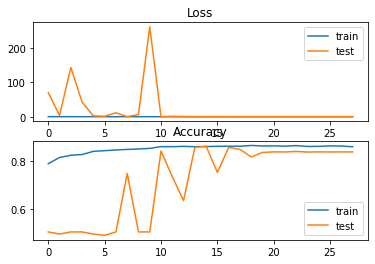

In [20]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [21]:
model.save('CNN_75x75_v1_less_complex_cnn.h5')

#Load Test Images

In [22]:
test_images = load('test_10k.npy')

In [23]:
x_test = test_images
y_test = load('labels_test10k.npy')

In [24]:
x_test.shape

(2944, 75, 75, 4)

In [25]:
y_test.shape

(2944,)

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


Logistic: f1=0.916 auc=0.9338662


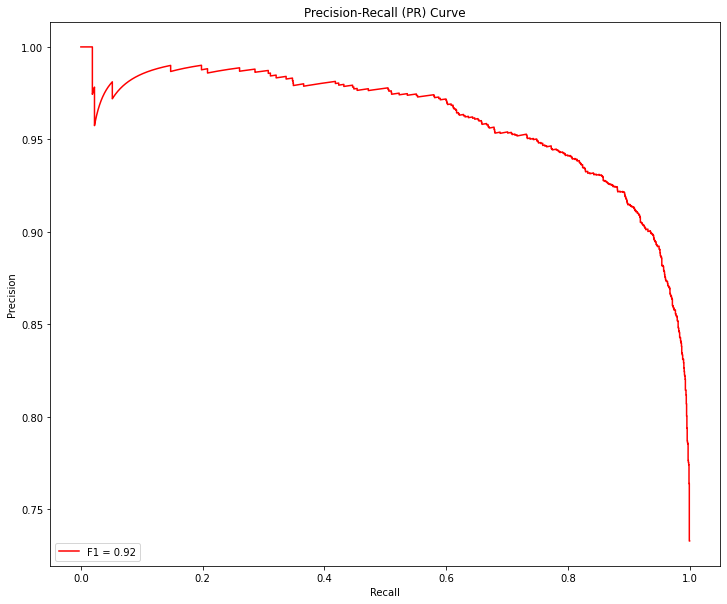

Accuracy: 0.8804347826086957
Average precision: 0.8697477330131765
recall: 0.9587884806355511
AUC:0.9323543440727162
Predicted  0.0   1.0
Actual              
0.0        661   269
1.0         83  1931


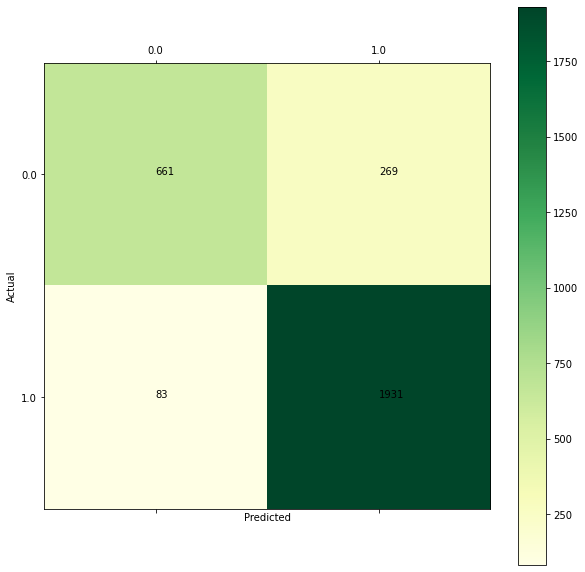

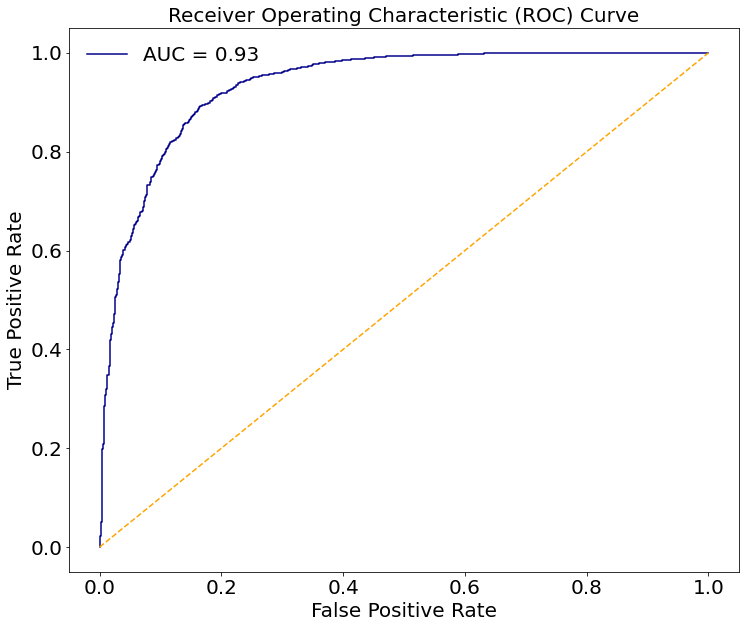

In [31]:
# Plotting/Printing Results
from keras import backend as K
from sklearn import metrics
np.random.seed(0)



lr_probs = model.predict_proba(x_test)    # Predict probabilities
yhat = model.predict(x_test)      # Predict class values
yhat = np.round(yhat)
#lr_f1, lr_auc = f1_score(y_test, yhat), metrics.auc(lr_recall, lr_precision)
lr_f1 = f1_score(y_test, yhat)
#lr_auc = roc_auc_score(y_test, lr_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
print('Logistic: f1=%.3f auc=%.7f' % (lr_f1, lr_auc))   # Summarise scores


''' plot the precision-recall curves '''

lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
#lr_precision, lr_recall, _ = precision_recall_curve(y_test, yhat)
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot(lr_recall, lr_precision, 'r-', label='F1 = %0.2f' %(lr_f1))
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend(loc='lower left')
plt.title('Precision-Recall (PR) Curve')
pyplot.show()

# Save precision and recall data to plot PR curve seperately
#np.savetxt("/content/drive/My Drive/Colab Notebooks/precision_HP.txt",lr_precision)
#np.savetxt("/content/drive/My Drive/Colab Notebooks/recall_HP.txt",lr_recall)


test_predictions = yhat             # Make a prediction on the test set
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy: " + str(accuracy))
average_precision = average_precision_score(y_test, test_predictions)
print("Average precision: " + str(average_precision))

from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_test, test_predictions)
auc = metrics.auc(recall, precision)
recall1 = recall_score(y_test, np.round(test_predictions))
print("recall: " + str(recall1))
print('AUC:' +str(auc))


# Report Confusion Matrix
y_actu = pd.Series(y_test.ravel(), name='Actual')
y_pred = pd.Series(np.round(test_predictions.ravel()), name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print(df_confusion)

# Plot confusion matrix
def plot_confusion_matrix(df_confusion, cmap='YlGn'):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks = np.arange(0,len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    for i in range(len(df_confusion.index)):
        for j in range(len(df_confusion.columns)):
            plt.text(j,i,str(df_confusion.iloc[i,j]))
    plt.show()

plot_confusion_matrix(df_confusion)



def plot_roc_curve(fpr, tpr):
    plt.rcParams['figure.figsize'] = [12, 10]
    plt.plot(fpr, tpr, color='darkblue', label='AUC = %0.2f' %(auc))
    plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=20)
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
    plt.legend(loc='best',numpoints = 1,frameon=False,prop={'size': 20})
    plt.gca().tick_params(labelsize=20)
    plt.savefig('ROC_AUC.png')
  
fpr, tpr, thresholds = roc_curve(y_test, lr_probs)
#fpr, tpr, thresholds = roc_curve(y_test, yhat)
#roc_auc = metrics.auc(fpr, tpr)
# Save tpr and fpr to plot seperate ROC curve
#np.savetxt("/content/drive/My Drive/Colab Notebooks/tpr.txt",tpr)
#np.savetxt("/content/drive/My Drive/Colab Notebooks/fpr.txt",fpr)
plot_roc_curve(fpr, tpr)
